In [1]:
#=======================================
## Tree-like neural network - Haberman
#=======================================

#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, concatenate, Dropout


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#----------------------------------------
# Load the Haberman dataset.

dataset = np.loadtxt("Haberman-Survival-Data.txt", delimiter = ",")

print(type(dataset))

print(dataset.shape)

which = lambda status: np.arange(len(status))[status]

index = which(dataset[:, 3] == 2)

dataset[index, 3] = 0

x_group = [[2], [0], [1]]

X = dataset[:, 0:3]
Y = dataset[:, 3]

print(np.unique(Y))

print(X.shape)
print(Y.shape)

X1 = dataset[:, x_group[0]]
X2 = dataset[:, x_group[1]]
X3 = dataset[:, x_group[2]]

print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)


<class 'numpy.ndarray'>
(306, 4)
[0. 1.]
(306, 3)
(306,)
(306, 1)
(306, 1)
(306, 1)
(306,)


In [3]:
#----------------------------------------
# Standardize the input and output data.

X_sample_mean = np.mean(X, axis = 0)
print(np.round(X_sample_mean, 4))

X_sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(X_sample_std, 4))

X1_sample_mean = X_sample_mean[x_group[0]]
print(np.round(X1_sample_mean, 4))

X1_sample_std = X_sample_std[x_group[0]]
print(np.round(X1_sample_std, 4))

X2_sample_mean = X_sample_mean[x_group[1]]
print(np.round(X2_sample_mean, 4))

X2_sample_std = X_sample_std[x_group[1]]
print(np.round(X2_sample_std, 4))

X3_sample_mean = X_sample_mean[x_group[2]]
print(np.round(X3_sample_mean, 4))

X3_sample_std = X_sample_std[x_group[2]]
print(np.round(X3_sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

X1_train = X_train[:, x_group[0]]
X2_train = X_train[:, x_group[1]]
X3_train = X_train[:, x_group[2]]

print(np.round(np.mean(X1_train, axis = 0), 4))
print(np.round(np.std(X1_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X2_train, axis = 0), 4))
print(np.round(np.std(X2_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X3_train, axis = 0), 4))
print(np.round(np.std(X3_train, axis = 0, ddof = 1), 4))

Y_train = Y


[52.4575 62.8529  4.0261]
[10.8035  3.2494  7.1897]
[4.0261]
[7.1897]
[52.4575]
[10.8035]
[62.8529]
[3.2494]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]


In [4]:
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [5]:
# 10-fold cross validation

cv_bc = []
cv_acc = []

for k in range(fold_num):
    # Build the tree like nn model
    input_g1 = Input(shape = (1,))
    x1 = input_g1
    t1 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x1)
    t1 = Dropout(rate = 0.1)(t1)
    #
    y11 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    y12 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    #
    input_g2 = Input(shape = (1,))
    x2 = concatenate([y11, input_g2], axis = 1)  # column bind
    t2 = Dense(units = 4, kernel_initializer = "uniform", activation = "relu")(x2)
    t2 = Dropout(rate = 0.1)(t2)
    #
    y21 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    y22 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    #
    input_g3 = Input(shape = (1,))
    x3 = concatenate([y21, input_g3], axis = 1)  # column bind
    t3 = Dense(units = 4, kernel_initializer = "uniform", activation = "relu")(x3)
    t3 = Dropout(rate = 0.1)(t3)
    #
    y31 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    y32 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    #
    x_final =  concatenate([y12, y22, y31, y32], axis = 1)  # column bind
    y_final = Dense(units = 5, kernel_initializer = "uniform", activation = "relu")(x_final)
    y_final = Dropout(rate = 0.1)(y_final)
    y_final = Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid")(y_final)
    response = y_final
    #
    model = Model(inputs = [input_g1, input_g2, input_g3], outputs = response)
    # Compile the model.
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit([X1_train[train_index], X2_train[train_index], X3_train[train_index]]
                        , Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 40, verbose = 1)
    # Evaluate the model.
    scores = model.evaluate([X1_train[test_index], X2_train[test_index], X3_train[test_index]]
                            , Y_train[test_index], verbose = 1)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_bc.append(scores[0])
    cv_acc.append(scores[1])


Train on 220 samples, validate on 55 samples
Epoch 1/1000
220/220 [==============================] - 1s 6ms/step - loss: 0.6926 - acc: 0.6909 - val_loss: 0.6914 - val_acc: 0.7818
Epoch 2/1000
220/220 [==============================] - 0s 173us/step - loss: 0.6912 - acc: 0.7273 - val_loss: 0.6897 - val_acc: 0.7818
Epoch 3/1000
220/220 [==============================] - 0s 123us/step - loss: 0.6898 - acc: 0.7273 - val_loss: 0.6879 - val_acc: 0.7818
Epoch 4/1000
220/220 [==============================] - 0s 160us/step - loss: 0.6884 - acc: 0.7273 - val_loss: 0.6861 - val_acc: 0.7818
Epoch 5/1000
220/220 [==============================] - 0s 137us/step - loss: 0.6870 - acc: 0.7273 - val_loss: 0.6842 - val_acc: 0.7818
Epoch 6/1000
220/220 [==============================] - 0s 131us/step - loss: 0.6854 - acc: 0.7273 - val_loss: 0.6822 - val_acc: 0.7818
Epoch 7/1000
220/220 [==============================] - 0s 127us/step - loss: 0.6837 - acc: 0.7273 - val_loss: 0.6801 - val_acc: 0.7818
Epoch

220/220 [==============================] - 0s 131us/step - loss: 0.5691 - acc: 0.7273 - val_loss: 0.4979 - val_acc: 0.7818
Epoch 61/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5719 - acc: 0.7273 - val_loss: 0.4970 - val_acc: 0.7818
Epoch 62/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5761 - acc: 0.7273 - val_loss: 0.4970 - val_acc: 0.7818
Epoch 63/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5696 - acc: 0.7273 - val_loss: 0.4957 - val_acc: 0.7818
Epoch 64/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5731 - acc: 0.7273 - val_loss: 0.4945 - val_acc: 0.7818
Epoch 65/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5733 - acc: 0.7273 - val_loss: 0.4932 - val_acc: 0.7818
Epoch 66/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5643 - acc: 0.7273 - val_loss: 0.4924 - val_acc: 0.7818
Epoch 67/1000
220/220 [==============================] -

Epoch 120/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5579 - acc: 0.7273 - val_loss: 0.4618 - val_acc: 0.7818
Epoch 121/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5603 - acc: 0.7273 - val_loss: 0.4620 - val_acc: 0.7818
Epoch 122/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5641 - acc: 0.7273 - val_loss: 0.4610 - val_acc: 0.7818
Epoch 123/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5544 - acc: 0.7273 - val_loss: 0.4616 - val_acc: 0.7818
Epoch 124/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5540 - acc: 0.7273 - val_loss: 0.4612 - val_acc: 0.7818
Epoch 125/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5560 - acc: 0.7273 - val_loss: 0.4610 - val_acc: 0.7818
Epoch 126/1000
220/220 [==============================] - 0s 247us/step - loss: 0.5636 - acc: 0.7273 - val_loss: 0.4621 - val_acc: 0.7818
Epoch 127/1000
220/220 [==========

220/220 [==============================] - 0s 140us/step - loss: 0.5601 - acc: 0.7273 - val_loss: 0.4464 - val_acc: 0.7818
Epoch 180/1000
220/220 [==============================] - 0s 348us/step - loss: 0.5542 - acc: 0.7273 - val_loss: 0.4471 - val_acc: 0.7818
Epoch 181/1000
220/220 [==============================] - 0s 200us/step - loss: 0.5528 - acc: 0.7273 - val_loss: 0.4467 - val_acc: 0.7818
Epoch 182/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5518 - acc: 0.7273 - val_loss: 0.4460 - val_acc: 0.7818
Epoch 183/1000
220/220 [==============================] - 0s 227us/step - loss: 0.5442 - acc: 0.7273 - val_loss: 0.4455 - val_acc: 0.7818
Epoch 184/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4448 - val_acc: 0.7818
Epoch 185/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5570 - acc: 0.7273 - val_loss: 0.4444 - val_acc: 0.7818
Epoch 186/1000
220/220 [=========================

220/220 [==============================] - 0s 100us/step - loss: 0.5505 - acc: 0.7273 - val_loss: 0.4390 - val_acc: 0.7818
Epoch 239/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5414 - acc: 0.7273 - val_loss: 0.4375 - val_acc: 0.7818
Epoch 240/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5554 - acc: 0.7273 - val_loss: 0.4378 - val_acc: 0.7818
Epoch 241/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5538 - acc: 0.7273 - val_loss: 0.4381 - val_acc: 0.7818
Epoch 242/1000
220/220 [==============================] - ETA: 0s - loss: 0.4568 - acc: 0.800 - 0s 125us/step - loss: 0.5449 - acc: 0.7273 - val_loss: 0.4382 - val_acc: 0.7818
Epoch 243/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5577 - acc: 0.7273 - val_loss: 0.4387 - val_acc: 0.7818
Epoch 244/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5577 - acc: 0.7273 - val_loss: 0.4397 - val_acc: 0.7818
Epoch 245/1

220/220 [==============================] - 0s 107us/step - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4314 - val_acc: 0.7818
Epoch 298/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5367 - acc: 0.7273 - val_loss: 0.4317 - val_acc: 0.7818
Epoch 299/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 300/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5412 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 301/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5441 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 302/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5391 - acc: 0.7273 - val_loss: 0.4314 - val_acc: 0.7818
Epoch 303/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5441 - acc: 0.7273 - val_loss: 0.4297 - val_acc: 0.7818
Epoch 304/1000
220/220 [=========================

220/220 [==============================] - 0s 126us/step - loss: 0.5359 - acc: 0.7409 - val_loss: 0.4352 - val_acc: 0.8000
Epoch 357/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5505 - acc: 0.7273 - val_loss: 0.4349 - val_acc: 0.8000
Epoch 358/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5404 - acc: 0.7409 - val_loss: 0.4340 - val_acc: 0.8000
Epoch 359/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5321 - acc: 0.7409 - val_loss: 0.4330 - val_acc: 0.8000
Epoch 360/1000
220/220 [==============================] - 0s 59us/step - loss: 0.5344 - acc: 0.7318 - val_loss: 0.4302 - val_acc: 0.8000
Epoch 361/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5367 - acc: 0.7364 - val_loss: 0.4286 - val_acc: 0.8000
Epoch 362/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5192 - acc: 0.7227 - val_loss: 0.4278 - val_acc: 0.8000
Epoch 363/1000
220/220 [==========================

220/220 [==============================] - 0s 71us/step - loss: 0.5701 - acc: 0.7364 - val_loss: 0.4276 - val_acc: 0.8182
Epoch 416/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5468 - acc: 0.7409 - val_loss: 0.4275 - val_acc: 0.8182
Epoch 417/1000
220/220 [==============================] - 0s 77us/step - loss: 0.5598 - acc: 0.7409 - val_loss: 0.4279 - val_acc: 0.8182
Epoch 418/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5287 - acc: 0.7545 - val_loss: 0.4273 - val_acc: 0.8182
Epoch 419/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5427 - acc: 0.7409 - val_loss: 0.4273 - val_acc: 0.8182
Epoch 420/1000
220/220 [==============================] - 0s 77us/step - loss: 0.5515 - acc: 0.7455 - val_loss: 0.4282 - val_acc: 0.8182
Epoch 421/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5305 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.8182
Epoch 422/1000
220/220 [============================

220/220 [==============================] - 0s 142us/step - loss: 0.5419 - acc: 0.7273 - val_loss: 0.4253 - val_acc: 0.8364
Epoch 475/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5557 - acc: 0.7500 - val_loss: 0.4247 - val_acc: 0.8364
Epoch 476/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5405 - acc: 0.7182 - val_loss: 0.4253 - val_acc: 0.8364
Epoch 477/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5336 - acc: 0.7455 - val_loss: 0.4267 - val_acc: 0.8364
Epoch 478/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5344 - acc: 0.7455 - val_loss: 0.4265 - val_acc: 0.8364
Epoch 479/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5409 - acc: 0.7455 - val_loss: 0.4262 - val_acc: 0.8364
Epoch 480/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5402 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.8364
Epoch 481/1000
220/220 [==========================

220/220 [==============================] - 0s 77us/step - loss: 0.5243 - acc: 0.7500 - val_loss: 0.4236 - val_acc: 0.8364
Epoch 534/1000
220/220 [==============================] - 0s 220us/step - loss: 0.5466 - acc: 0.7273 - val_loss: 0.4232 - val_acc: 0.8364
Epoch 535/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5393 - acc: 0.7545 - val_loss: 0.4224 - val_acc: 0.8364
Epoch 536/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5398 - acc: 0.7364 - val_loss: 0.4227 - val_acc: 0.8364
Epoch 537/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5457 - acc: 0.7455 - val_loss: 0.4226 - val_acc: 0.8364
Epoch 538/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5479 - acc: 0.7364 - val_loss: 0.4231 - val_acc: 0.8364
Epoch 539/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5197 - acc: 0.7364 - val_loss: 0.4231 - val_acc: 0.8364
Epoch 540/1000
220/220 [==========================

220/220 [==============================] - 0s 166us/step - loss: 0.5513 - acc: 0.7364 - val_loss: 0.4191 - val_acc: 0.8364
Epoch 593/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5348 - acc: 0.7455 - val_loss: 0.4208 - val_acc: 0.8364
Epoch 594/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5512 - acc: 0.7455 - val_loss: 0.4218 - val_acc: 0.8364
Epoch 595/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5502 - acc: 0.7273 - val_loss: 0.4222 - val_acc: 0.8364
Epoch 596/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5413 - acc: 0.7227 - val_loss: 0.4225 - val_acc: 0.8364
Epoch 597/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5311 - acc: 0.7455 - val_loss: 0.4240 - val_acc: 0.8364
Epoch 598/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5497 - acc: 0.7455 - val_loss: 0.4248 - val_acc: 0.8364
Epoch 599/1000
220/220 [============================

220/220 [==============================] - 0s 147us/step - loss: 0.5484 - acc: 0.7227 - val_loss: 0.4204 - val_acc: 0.8364
Epoch 652/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5424 - acc: 0.7364 - val_loss: 0.4214 - val_acc: 0.8364
Epoch 653/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5401 - acc: 0.7500 - val_loss: 0.4210 - val_acc: 0.8364
Epoch 654/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5437 - acc: 0.7455 - val_loss: 0.4218 - val_acc: 0.8364
Epoch 655/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5521 - acc: 0.7364 - val_loss: 0.4228 - val_acc: 0.8364
Epoch 656/1000
220/220 [==============================] - 0s 201us/step - loss: 0.5236 - acc: 0.7591 - val_loss: 0.4224 - val_acc: 0.8364
Epoch 657/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5314 - acc: 0.7364 - val_loss: 0.4215 - val_acc: 0.8364
Epoch 658/1000
220/220 [==========================

220/220 [==============================] - 0s 71us/step - loss: 0.5334 - acc: 0.7318 - val_loss: 0.4192 - val_acc: 0.8364
Epoch 711/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5428 - acc: 0.7591 - val_loss: 0.4196 - val_acc: 0.8364
Epoch 712/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5374 - acc: 0.7364 - val_loss: 0.4196 - val_acc: 0.8364
Epoch 713/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5096 - acc: 0.7409 - val_loss: 0.4185 - val_acc: 0.8364
Epoch 714/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5382 - acc: 0.7227 - val_loss: 0.4181 - val_acc: 0.8364
Epoch 715/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5392 - acc: 0.7318 - val_loss: 0.4169 - val_acc: 0.8364
Epoch 716/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5451 - acc: 0.7500 - val_loss: 0.4183 - val_acc: 0.8364
Epoch 717/1000
220/220 [===========================

220/220 [==============================] - 0s 122us/step - loss: 0.5479 - acc: 0.7500 - val_loss: 0.4188 - val_acc: 0.8364
Epoch 770/1000
220/220 [==============================] - 0s 70us/step - loss: 0.5484 - acc: 0.7273 - val_loss: 0.4180 - val_acc: 0.8364
Epoch 771/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5288 - acc: 0.7545 - val_loss: 0.4182 - val_acc: 0.8364
Epoch 772/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5352 - acc: 0.7500 - val_loss: 0.4185 - val_acc: 0.8364
Epoch 773/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5431 - acc: 0.7500 - val_loss: 0.4188 - val_acc: 0.8364
Epoch 774/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5264 - acc: 0.7545 - val_loss: 0.4188 - val_acc: 0.8364
Epoch 775/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5301 - acc: 0.7500 - val_loss: 0.4184 - val_acc: 0.8364
Epoch 776/1000
220/220 [============================

220/220 [==============================] - 0s 151us/step - loss: 0.5287 - acc: 0.7591 - val_loss: 0.4187 - val_acc: 0.8364
Epoch 829/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5413 - acc: 0.7591 - val_loss: 0.4196 - val_acc: 0.8364
Epoch 830/1000
220/220 [==============================] - 0s 203us/step - loss: 0.5346 - acc: 0.7409 - val_loss: 0.4187 - val_acc: 0.8364
Epoch 831/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5508 - acc: 0.7409 - val_loss: 0.4184 - val_acc: 0.8364
Epoch 832/1000
220/220 [==============================] - 0s 215us/step - loss: 0.5160 - acc: 0.7455 - val_loss: 0.4179 - val_acc: 0.8364
Epoch 833/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5225 - acc: 0.7545 - val_loss: 0.4175 - val_acc: 0.8364
Epoch 834/1000
220/220 [==============================] - 0s 238us/step - loss: 0.5346 - acc: 0.7545 - val_loss: 0.4172 - val_acc: 0.8364
Epoch 835/1000
220/220 [==========================

220/220 [==============================] - 0s 163us/step - loss: 0.5363 - acc: 0.7500 - val_loss: 0.4203 - val_acc: 0.8364
Epoch 888/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5426 - acc: 0.7455 - val_loss: 0.4203 - val_acc: 0.8364
Epoch 889/1000
220/220 [==============================] - 0s 219us/step - loss: 0.5216 - acc: 0.7455 - val_loss: 0.4196 - val_acc: 0.8364
Epoch 890/1000
220/220 [==============================] - 0s 231us/step - loss: 0.5409 - acc: 0.7500 - val_loss: 0.4188 - val_acc: 0.8364
Epoch 891/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5304 - acc: 0.7318 - val_loss: 0.4176 - val_acc: 0.8364
Epoch 892/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5361 - acc: 0.7409 - val_loss: 0.4169 - val_acc: 0.8364
Epoch 893/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5284 - acc: 0.7455 - val_loss: 0.4167 - val_acc: 0.8364
Epoch 894/1000
220/220 [==========================

220/220 [==============================] - 0s 79us/step - loss: 0.5422 - acc: 0.7682 - val_loss: 0.4166 - val_acc: 0.8364
Epoch 947/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5376 - acc: 0.7682 - val_loss: 0.4164 - val_acc: 0.8364
Epoch 948/1000
220/220 [==============================] - 0s 56us/step - loss: 0.5350 - acc: 0.7682 - val_loss: 0.4158 - val_acc: 0.8364
Epoch 949/1000
220/220 [==============================] - 0s 74us/step - loss: 0.5385 - acc: 0.7545 - val_loss: 0.4159 - val_acc: 0.8364
Epoch 950/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5185 - acc: 0.7500 - val_loss: 0.4149 - val_acc: 0.8364
Epoch 951/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5344 - acc: 0.7545 - val_loss: 0.4152 - val_acc: 0.8364
Epoch 952/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5374 - acc: 0.7455 - val_loss: 0.4153 - val_acc: 0.8364
Epoch 953/1000
220/220 [==============================

Epoch 5/1000
220/220 [==============================] - 0s 186us/step - loss: 0.6873 - acc: 0.7273 - val_loss: 0.6850 - val_acc: 0.7818
Epoch 6/1000
220/220 [==============================] - 0s 183us/step - loss: 0.6860 - acc: 0.7273 - val_loss: 0.6834 - val_acc: 0.7818
Epoch 7/1000
220/220 [==============================] - 0s 230us/step - loss: 0.6847 - acc: 0.7273 - val_loss: 0.6816 - val_acc: 0.7818
Epoch 8/1000
220/220 [==============================] - 0s 148us/step - loss: 0.6833 - acc: 0.7273 - val_loss: 0.6798 - val_acc: 0.7818
Epoch 9/1000
220/220 [==============================] - 0s 219us/step - loss: 0.6820 - acc: 0.7273 - val_loss: 0.6780 - val_acc: 0.7818
Epoch 10/1000
220/220 [==============================] - 0s 158us/step - loss: 0.6804 - acc: 0.7273 - val_loss: 0.6761 - val_acc: 0.7818
Epoch 11/1000
220/220 [==============================] - 0s 101us/step - loss: 0.6788 - acc: 0.7273 - val_loss: 0.6741 - val_acc: 0.7818
Epoch 12/1000
220/220 [=======================

Epoch 65/1000
220/220 [==============================] - 0s 196us/step - loss: 0.5797 - acc: 0.7273 - val_loss: 0.5306 - val_acc: 0.7818
Epoch 66/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5714 - acc: 0.7273 - val_loss: 0.5301 - val_acc: 0.7818
Epoch 67/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5798 - acc: 0.7273 - val_loss: 0.5294 - val_acc: 0.7818
Epoch 68/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5965 - acc: 0.7273 - val_loss: 0.5296 - val_acc: 0.7818
Epoch 69/1000
220/220 [==============================] - 0s 227us/step - loss: 0.5806 - acc: 0.7273 - val_loss: 0.5293 - val_acc: 0.7818
Epoch 70/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5849 - acc: 0.7273 - val_loss: 0.5295 - val_acc: 0.7818
Epoch 71/1000
220/220 [==============================] - 0s 277us/step - loss: 0.5765 - acc: 0.7273 - val_loss: 0.5295 - val_acc: 0.7818
Epoch 72/1000
220/220 [==================

Epoch 125/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5721 - acc: 0.7273 - val_loss: 0.5201 - val_acc: 0.7818
Epoch 126/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5990 - acc: 0.7273 - val_loss: 0.5200 - val_acc: 0.7818
Epoch 127/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5817 - acc: 0.7273 - val_loss: 0.5208 - val_acc: 0.7818
Epoch 128/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5709 - acc: 0.7273 - val_loss: 0.5215 - val_acc: 0.7818
Epoch 129/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5870 - acc: 0.7273 - val_loss: 0.5212 - val_acc: 0.7818
Epoch 130/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5761 - acc: 0.7273 - val_loss: 0.5213 - val_acc: 0.7818
Epoch 131/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5866 - acc: 0.7273 - val_loss: 0.5215 - val_acc: 0.7818
Epoch 132/1000
220/220 [=============

220/220 [==============================] - 0s 174us/step - loss: 0.5834 - acc: 0.7273 - val_loss: 0.5053 - val_acc: 0.7818
Epoch 185/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5777 - acc: 0.7273 - val_loss: 0.5060 - val_acc: 0.7818
Epoch 186/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5782 - acc: 0.7273 - val_loss: 0.5076 - val_acc: 0.7818
Epoch 187/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5716 - acc: 0.7273 - val_loss: 0.5073 - val_acc: 0.7818
Epoch 188/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5737 - acc: 0.7273 - val_loss: 0.5064 - val_acc: 0.7818
Epoch 189/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5796 - acc: 0.7273 - val_loss: 0.5060 - val_acc: 0.7818
Epoch 190/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5662 - acc: 0.7273 - val_loss: 0.5061 - val_acc: 0.7818
Epoch 191/1000
220/220 [==========================

220/220 [==============================] - 0s 220us/step - loss: 0.5636 - acc: 0.7273 - val_loss: 0.4985 - val_acc: 0.7818
Epoch 244/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5699 - acc: 0.7273 - val_loss: 0.4990 - val_acc: 0.7818
Epoch 245/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5794 - acc: 0.7273 - val_loss: 0.4996 - val_acc: 0.7818
Epoch 246/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5728 - acc: 0.7273 - val_loss: 0.4991 - val_acc: 0.7818
Epoch 247/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5652 - acc: 0.7273 - val_loss: 0.5004 - val_acc: 0.7818
Epoch 248/1000
220/220 [==============================] - 0s 41us/step - loss: 0.5791 - acc: 0.7273 - val_loss: 0.5004 - val_acc: 0.7818
Epoch 249/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5629 - acc: 0.7273 - val_loss: 0.5002 - val_acc: 0.7818
Epoch 250/1000
220/220 [===========================

220/220 [==============================] - 0s 122us/step - loss: 0.5717 - acc: 0.7273 - val_loss: 0.4890 - val_acc: 0.7818
Epoch 303/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5737 - acc: 0.7273 - val_loss: 0.4888 - val_acc: 0.7818
Epoch 304/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5705 - acc: 0.7273 - val_loss: 0.4888 - val_acc: 0.7818
Epoch 305/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5669 - acc: 0.7273 - val_loss: 0.4888 - val_acc: 0.7818
Epoch 306/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5688 - acc: 0.7273 - val_loss: 0.4892 - val_acc: 0.7818
Epoch 307/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5570 - acc: 0.7273 - val_loss: 0.4887 - val_acc: 0.7818
Epoch 308/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5529 - acc: 0.7273 - val_loss: 0.4879 - val_acc: 0.7818
Epoch 309/1000
220/220 [=========================

220/220 [==============================] - 0s 173us/step - loss: 0.5533 - acc: 0.7273 - val_loss: 0.4911 - val_acc: 0.7818
Epoch 362/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5650 - acc: 0.7273 - val_loss: 0.4896 - val_acc: 0.7818
Epoch 363/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4888 - val_acc: 0.7818
Epoch 364/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5618 - acc: 0.7273 - val_loss: 0.4885 - val_acc: 0.7818
Epoch 365/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5639 - acc: 0.7273 - val_loss: 0.4880 - val_acc: 0.7818
Epoch 366/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5659 - acc: 0.7273 - val_loss: 0.4874 - val_acc: 0.7818
Epoch 367/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5775 - acc: 0.7273 - val_loss: 0.4871 - val_acc: 0.7818
Epoch 368/1000
220/220 [=========================

220/220 [==============================] - 0s 115us/step - loss: 0.5598 - acc: 0.7273 - val_loss: 0.4838 - val_acc: 0.7818
Epoch 421/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5642 - acc: 0.7273 - val_loss: 0.4842 - val_acc: 0.7818
Epoch 422/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5621 - acc: 0.7273 - val_loss: 0.4832 - val_acc: 0.7818
Epoch 423/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5834 - acc: 0.7273 - val_loss: 0.4838 - val_acc: 0.7818
Epoch 424/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5602 - acc: 0.7273 - val_loss: 0.4846 - val_acc: 0.7818
Epoch 425/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4855 - val_acc: 0.7818
Epoch 426/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5774 - acc: 0.7273 - val_loss: 0.4861 - val_acc: 0.7818
Epoch 427/1000
220/220 [===========================

220/220 [==============================] - 0s 76us/step - loss: 0.5666 - acc: 0.7273 - val_loss: 0.4820 - val_acc: 0.7818
Epoch 480/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5696 - acc: 0.7273 - val_loss: 0.4819 - val_acc: 0.7818
Epoch 481/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5674 - acc: 0.7273 - val_loss: 0.4820 - val_acc: 0.7818
Epoch 482/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5612 - acc: 0.7273 - val_loss: 0.4826 - val_acc: 0.7818
Epoch 483/1000
220/220 [==============================] - 0s 204us/step - loss: 0.5701 - acc: 0.7273 - val_loss: 0.4827 - val_acc: 0.7818
Epoch 484/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5760 - acc: 0.7273 - val_loss: 0.4839 - val_acc: 0.7818
Epoch 485/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5423 - acc: 0.7273 - val_loss: 0.4831 - val_acc: 0.7818
Epoch 486/1000
220/220 [===========================

220/220 [==============================] - 0s 180us/step - loss: 0.5634 - acc: 0.7273 - val_loss: 0.4843 - val_acc: 0.7818
Epoch 539/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5699 - acc: 0.7273 - val_loss: 0.4841 - val_acc: 0.7818
Epoch 540/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5758 - acc: 0.7273 - val_loss: 0.4844 - val_acc: 0.7818
Epoch 541/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5702 - acc: 0.7273 - val_loss: 0.4852 - val_acc: 0.7818
Epoch 542/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5555 - acc: 0.7273 - val_loss: 0.4846 - val_acc: 0.7818
Epoch 543/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5540 - acc: 0.7273 - val_loss: 0.4840 - val_acc: 0.7818
Epoch 544/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5675 - acc: 0.7273 - val_loss: 0.4833 - val_acc: 0.7818
Epoch 545/1000
220/220 [=============================

220/220 [==============================] - 0s 169us/step - loss: 0.5759 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7818
Epoch 598/1000
220/220 [==============================] - 0s 195us/step - loss: 0.5623 - acc: 0.7273 - val_loss: 0.4800 - val_acc: 0.7818
Epoch 599/1000
220/220 [==============================] - 0s 200us/step - loss: 0.5477 - acc: 0.7273 - val_loss: 0.4793 - val_acc: 0.7818
Epoch 600/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5671 - acc: 0.7273 - val_loss: 0.4779 - val_acc: 0.7818
Epoch 601/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5599 - acc: 0.7273 - val_loss: 0.4772 - val_acc: 0.7818
Epoch 602/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4766 - val_acc: 0.7818
Epoch 603/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5667 - acc: 0.7273 - val_loss: 0.4775 - val_acc: 0.7818
Epoch 604/1000
220/220 [=========================

220/220 [==============================] - 0s 162us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4819 - val_acc: 0.7818
Epoch 657/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5667 - acc: 0.7273 - val_loss: 0.4817 - val_acc: 0.7818
Epoch 658/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4803 - val_acc: 0.7818
Epoch 659/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5635 - acc: 0.7273 - val_loss: 0.4796 - val_acc: 0.7818
Epoch 660/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5575 - acc: 0.7273 - val_loss: 0.4780 - val_acc: 0.7818
Epoch 661/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5722 - acc: 0.7273 - val_loss: 0.4777 - val_acc: 0.7818
Epoch 662/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5697 - acc: 0.7273 - val_loss: 0.4784 - val_acc: 0.7818
Epoch 663/1000
220/220 [==========================

220/220 [==============================] - 0s 187us/step - loss: 0.5595 - acc: 0.7273 - val_loss: 0.4800 - val_acc: 0.7818
Epoch 716/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5743 - acc: 0.7273 - val_loss: 0.4799 - val_acc: 0.7818
Epoch 717/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5683 - acc: 0.7273 - val_loss: 0.4811 - val_acc: 0.7818
Epoch 718/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5624 - acc: 0.7273 - val_loss: 0.4826 - val_acc: 0.7818
Epoch 719/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5688 - acc: 0.7273 - val_loss: 0.4830 - val_acc: 0.7818
Epoch 720/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5745 - acc: 0.7273 - val_loss: 0.4852 - val_acc: 0.7818
Epoch 721/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5617 - acc: 0.7273 - val_loss: 0.4867 - val_acc: 0.7818
Epoch 722/1000
220/220 [==========================

220/220 [==============================] - 0s 153us/step - loss: 0.5550 - acc: 0.7273 - val_loss: 0.4830 - val_acc: 0.7818
Epoch 775/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5673 - acc: 0.7273 - val_loss: 0.4823 - val_acc: 0.7818
Epoch 776/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4813 - val_acc: 0.7818
Epoch 777/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5550 - acc: 0.7273 - val_loss: 0.4800 - val_acc: 0.7818
Epoch 778/1000
220/220 [==============================] - 0s 80us/step - loss: 0.5755 - acc: 0.7273 - val_loss: 0.4793 - val_acc: 0.7818
Epoch 779/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5584 - acc: 0.7273 - val_loss: 0.4791 - val_acc: 0.7818
Epoch 780/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5746 - acc: 0.7273 - val_loss: 0.4790 - val_acc: 0.7818
Epoch 781/1000
220/220 [===========================

220/220 [==============================] - 0s 148us/step - loss: 0.5699 - acc: 0.7273 - val_loss: 0.4829 - val_acc: 0.7818
Epoch 834/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5614 - acc: 0.7273 - val_loss: 0.4817 - val_acc: 0.7818
Epoch 835/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5824 - acc: 0.7273 - val_loss: 0.4815 - val_acc: 0.7818
Epoch 836/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5571 - acc: 0.7273 - val_loss: 0.4816 - val_acc: 0.7818
Epoch 837/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5685 - acc: 0.7273 - val_loss: 0.4811 - val_acc: 0.7818
Epoch 838/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5745 - acc: 0.7273 - val_loss: 0.4803 - val_acc: 0.7818
Epoch 839/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4804 - val_acc: 0.7818
Epoch 840/1000
220/220 [==========================

220/220 [==============================] - 0s 185us/step - loss: 0.5707 - acc: 0.7273 - val_loss: 0.4767 - val_acc: 0.7818
Epoch 893/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5643 - acc: 0.7273 - val_loss: 0.4772 - val_acc: 0.7818
Epoch 894/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5616 - acc: 0.7273 - val_loss: 0.4777 - val_acc: 0.7818
Epoch 895/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5633 - acc: 0.7273 - val_loss: 0.4784 - val_acc: 0.7818
Epoch 896/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5517 - acc: 0.7273 - val_loss: 0.4790 - val_acc: 0.7818
Epoch 897/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5696 - acc: 0.7273 - val_loss: 0.4791 - val_acc: 0.7818
Epoch 898/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5424 - acc: 0.7273 - val_loss: 0.4786 - val_acc: 0.7818
Epoch 899/1000
220/220 [=========================

220/220 [==============================] - 0s 164us/step - loss: 0.5603 - acc: 0.7273 - val_loss: 0.4822 - val_acc: 0.7818
Epoch 952/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5613 - acc: 0.7273 - val_loss: 0.4818 - val_acc: 0.7818
Epoch 953/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5501 - acc: 0.7273 - val_loss: 0.4804 - val_acc: 0.7818
Epoch 954/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5545 - acc: 0.7273 - val_loss: 0.4781 - val_acc: 0.7818
Epoch 955/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5679 - acc: 0.7273 - val_loss: 0.4776 - val_acc: 0.7818
Epoch 956/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5717 - acc: 0.7273 - val_loss: 0.4786 - val_acc: 0.7818
Epoch 957/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5739 - acc: 0.7273 - val_loss: 0.4801 - val_acc: 0.7818
Epoch 958/1000
220/220 [=========================

Epoch 10/1000
220/220 [==============================] - 0s 173us/step - loss: 0.6821 - acc: 0.7182 - val_loss: 0.6778 - val_acc: 0.7818
Epoch 11/1000
220/220 [==============================] - 0s 176us/step - loss: 0.6809 - acc: 0.7182 - val_loss: 0.6763 - val_acc: 0.7818
Epoch 12/1000
220/220 [==============================] - 0s 159us/step - loss: 0.6797 - acc: 0.7182 - val_loss: 0.6748 - val_acc: 0.7818
Epoch 13/1000
220/220 [==============================] - 0s 135us/step - loss: 0.6786 - acc: 0.7182 - val_loss: 0.6733 - val_acc: 0.7818
Epoch 14/1000
220/220 [==============================] - 0s 101us/step - loss: 0.6775 - acc: 0.7182 - val_loss: 0.6718 - val_acc: 0.7818
Epoch 15/1000
220/220 [==============================] - 0s 164us/step - loss: 0.6764 - acc: 0.7182 - val_loss: 0.6703 - val_acc: 0.7818
Epoch 16/1000
220/220 [==============================] - 0s 99us/step - loss: 0.6753 - acc: 0.7182 - val_loss: 0.6689 - val_acc: 0.7818
Epoch 17/1000
220/220 [===================

220/220 [==============================] - 0s 146us/step - loss: 0.6326 - acc: 0.7182 - val_loss: 0.6100 - val_acc: 0.7818
Epoch 70/1000
220/220 [==============================] - 0s 145us/step - loss: 0.6320 - acc: 0.7182 - val_loss: 0.6092 - val_acc: 0.7818
Epoch 71/1000
220/220 [==============================] - 0s 144us/step - loss: 0.6314 - acc: 0.7182 - val_loss: 0.6083 - val_acc: 0.7818
Epoch 72/1000
220/220 [==============================] - 0s 162us/step - loss: 0.6308 - acc: 0.7182 - val_loss: 0.6075 - val_acc: 0.7818
Epoch 73/1000
220/220 [==============================] - 0s 143us/step - loss: 0.6303 - acc: 0.7182 - val_loss: 0.6067 - val_acc: 0.7818
Epoch 74/1000
220/220 [==============================] - 0s 104us/step - loss: 0.6298 - acc: 0.7182 - val_loss: 0.6059 - val_acc: 0.7818
Epoch 75/1000
220/220 [==============================] - 0s 164us/step - loss: 0.6292 - acc: 0.7182 - val_loss: 0.6050 - val_acc: 0.7818
Epoch 76/1000
220/220 [==============================] 

Epoch 129/1000
220/220 [==============================] - 0s 128us/step - loss: 0.6087 - acc: 0.7182 - val_loss: 0.5721 - val_acc: 0.7818
Epoch 130/1000
220/220 [==============================] - 0s 152us/step - loss: 0.6085 - acc: 0.7182 - val_loss: 0.5716 - val_acc: 0.7818
Epoch 131/1000
220/220 [==============================] - 0s 160us/step - loss: 0.6082 - acc: 0.7182 - val_loss: 0.5711 - val_acc: 0.7818
Epoch 132/1000
220/220 [==============================] - 0s 162us/step - loss: 0.6080 - acc: 0.7182 - val_loss: 0.5707 - val_acc: 0.7818
Epoch 133/1000
220/220 [==============================] - 0s 153us/step - loss: 0.6077 - acc: 0.7182 - val_loss: 0.5702 - val_acc: 0.7818
Epoch 134/1000
220/220 [==============================] - 0s 188us/step - loss: 0.6075 - acc: 0.7182 - val_loss: 0.5698 - val_acc: 0.7818
Epoch 135/1000
220/220 [==============================] - 0s 205us/step - loss: 0.6073 - acc: 0.7182 - val_loss: 0.5694 - val_acc: 0.7818
Epoch 136/1000
220/220 [==========

220/220 [==============================] - 0s 114us/step - loss: 0.5994 - acc: 0.7182 - val_loss: 0.5533 - val_acc: 0.7818
Epoch 189/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5993 - acc: 0.7182 - val_loss: 0.5531 - val_acc: 0.7818
Epoch 190/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5992 - acc: 0.7182 - val_loss: 0.5529 - val_acc: 0.7818
Epoch 191/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5991 - acc: 0.7182 - val_loss: 0.5527 - val_acc: 0.7818
Epoch 192/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5991 - acc: 0.7182 - val_loss: 0.5525 - val_acc: 0.7818
Epoch 193/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5990 - acc: 0.7182 - val_loss: 0.5523 - val_acc: 0.7818
Epoch 194/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5989 - acc: 0.7182 - val_loss: 0.5521 - val_acc: 0.7818
Epoch 195/1000
220/220 [=========================

220/220 [==============================] - 0s 125us/step - loss: 0.5961 - acc: 0.7182 - val_loss: 0.5440 - val_acc: 0.7818
Epoch 248/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5961 - acc: 0.7182 - val_loss: 0.5439 - val_acc: 0.7818
Epoch 249/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5960 - acc: 0.7182 - val_loss: 0.5437 - val_acc: 0.7818
Epoch 250/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5960 - acc: 0.7182 - val_loss: 0.5436 - val_acc: 0.7818
Epoch 251/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5960 - acc: 0.7182 - val_loss: 0.5435 - val_acc: 0.7818
Epoch 252/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5959 - acc: 0.7182 - val_loss: 0.5434 - val_acc: 0.7818
Epoch 253/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5959 - acc: 0.7182 - val_loss: 0.5433 - val_acc: 0.7818
Epoch 254/1000
220/220 [=========================

220/220 [==============================] - 0s 138us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5391 - val_acc: 0.7818
Epoch 307/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5390 - val_acc: 0.7818
Epoch 308/1000
220/220 [==============================] - 0s 186us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5390 - val_acc: 0.7818
Epoch 309/1000
220/220 [==============================] - 0s 235us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5390 - val_acc: 0.7818
Epoch 310/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5389 - val_acc: 0.7818
Epoch 311/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5389 - val_acc: 0.7818
Epoch 312/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5950 - acc: 0.7182 - val_loss: 0.5389 - val_acc: 0.7818
Epoch 313/1000
220/220 [=========================

220/220 [==============================] - 0s 160us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 366/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 367/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 368/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 369/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 370/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 371/1000
220/220 [==============================] - 0s 218us/step - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 372/1000
220/220 [=========================

220/220 [==============================] - 0s 140us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 425/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 426/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 427/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 428/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 429/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 430/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5362 - val_acc: 0.7818
Epoch 431/1000
220/220 [=========================

220/220 [==============================] - 0s 145us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 484/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 485/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 486/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 487/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 488/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 489/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 490/1000
220/220 [=========================

220/220 [==============================] - 0s 127us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 543/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 544/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 545/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 546/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 547/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 548/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 549/1000
220/220 [==========================

Epoch 601/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 602/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 603/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 604/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 605/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 606/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 607/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 608/1000
220/220 [==========

220/220 [==============================] - 0s 147us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 661/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 662/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 663/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 664/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 665/1000
220/220 [==============================] - 0s 63us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 666/1000
220/220 [==============================] - 0s 53us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5350 - val_acc: 0.7818
Epoch 667/1000
220/220 [============================

220/220 [==============================] - 0s 153us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 720/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 721/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 722/1000
220/220 [==============================] - 0s 213us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 723/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 724/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 725/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 726/1000
220/220 [=========================

220/220 [==============================] - 0s 134us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 779/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 780/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 781/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 782/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 783/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 784/1000
220/220 [==============================] - 0s 180us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 785/1000
220/220 [=========================

Epoch 837/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 838/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 839/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 840/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 841/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 842/1000
220/220 [==============================] - 0s 217us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 843/1000
220/220 [==============================] - 0s 69us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 844/1000
220/220 [============

220/220 [==============================] - 0s 51us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 897/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 898/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 899/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 900/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 901/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 902/1000
220/220 [==============================] - 0s 199us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 903/1000
220/220 [==========================

220/220 [==============================] - 0s 131us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 956/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 957/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 958/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 959/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 960/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 961/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 962/1000
220/220 [=========================

220/220 [==============================] - 0s 154us/step - loss: 0.6678 - acc: 0.7318 - val_loss: 0.6595 - val_acc: 0.7818
Epoch 14/1000
220/220 [==============================] - 0s 111us/step - loss: 0.6639 - acc: 0.7318 - val_loss: 0.6552 - val_acc: 0.7818
Epoch 15/1000
220/220 [==============================] - 0s 140us/step - loss: 0.6605 - acc: 0.7318 - val_loss: 0.6504 - val_acc: 0.7818
Epoch 16/1000
220/220 [==============================] - 0s 136us/step - loss: 0.6577 - acc: 0.7318 - val_loss: 0.6454 - val_acc: 0.7818
Epoch 17/1000
220/220 [==============================] - 0s 337us/step - loss: 0.6537 - acc: 0.7318 - val_loss: 0.6400 - val_acc: 0.7818
Epoch 18/1000
220/220 [==============================] - 0s 161us/step - loss: 0.6491 - acc: 0.7318 - val_loss: 0.6340 - val_acc: 0.7818
Epoch 19/1000
220/220 [==============================] - 0s 132us/step - loss: 0.6451 - acc: 0.7318 - val_loss: 0.6279 - val_acc: 0.7818
Epoch 20/1000
220/220 [==============================] 

Epoch 73/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5628 - acc: 0.7318 - val_loss: 0.4890 - val_acc: 0.7818
Epoch 74/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5637 - acc: 0.7318 - val_loss: 0.4887 - val_acc: 0.7818
Epoch 75/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5622 - acc: 0.7318 - val_loss: 0.4880 - val_acc: 0.7818
Epoch 76/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5611 - acc: 0.7318 - val_loss: 0.4871 - val_acc: 0.7818
Epoch 77/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5611 - acc: 0.7318 - val_loss: 0.4862 - val_acc: 0.7818
Epoch 78/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5526 - acc: 0.7318 - val_loss: 0.4853 - val_acc: 0.7818
Epoch 79/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5596 - acc: 0.7318 - val_loss: 0.4835 - val_acc: 0.7818
Epoch 80/1000
220/220 [==================

220/220 [==============================] - 0s 125us/step - loss: 0.5595 - acc: 0.7318 - val_loss: 0.4581 - val_acc: 0.7818
Epoch 133/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5560 - acc: 0.7318 - val_loss: 0.4577 - val_acc: 0.7818
Epoch 134/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5602 - acc: 0.7318 - val_loss: 0.4583 - val_acc: 0.7818
Epoch 135/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5466 - acc: 0.7318 - val_loss: 0.4576 - val_acc: 0.7818
Epoch 136/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5407 - acc: 0.7318 - val_loss: 0.4570 - val_acc: 0.7818
Epoch 137/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5456 - acc: 0.7318 - val_loss: 0.4556 - val_acc: 0.7818
Epoch 138/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5553 - acc: 0.7318 - val_loss: 0.4546 - val_acc: 0.7818
Epoch 139/1000
220/220 [=========================

220/220 [==============================] - 0s 146us/step - loss: 0.5333 - acc: 0.7318 - val_loss: 0.4385 - val_acc: 0.7818
Epoch 192/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5301 - acc: 0.7318 - val_loss: 0.4368 - val_acc: 0.7818
Epoch 193/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5333 - acc: 0.7318 - val_loss: 0.4353 - val_acc: 0.7818
Epoch 194/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5489 - acc: 0.7318 - val_loss: 0.4349 - val_acc: 0.7818
Epoch 195/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5390 - acc: 0.7318 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 196/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5565 - acc: 0.7318 - val_loss: 0.4352 - val_acc: 0.7818
Epoch 197/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5366 - acc: 0.7318 - val_loss: 0.4351 - val_acc: 0.7818
Epoch 198/1000
220/220 [=========================

220/220 [==============================] - 0s 144us/step - loss: 0.5273 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 251/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5446 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 252/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5298 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 253/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5317 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 254/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5439 - acc: 0.7318 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 255/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5411 - acc: 0.7318 - val_loss: 0.4259 - val_acc: 0.7818
Epoch 256/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5433 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.7818
Epoch 257/1000
220/220 [=========================

220/220 [==============================] - 0s 102us/step - loss: 0.5434 - acc: 0.7318 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 310/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5257 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 311/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5447 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 312/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4276 - val_acc: 0.7818
Epoch 313/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5363 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 314/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5413 - acc: 0.7318 - val_loss: 0.4289 - val_acc: 0.7818
Epoch 315/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5284 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 316/1000
220/220 [=========================

220/220 [==============================] - 0s 128us/step - loss: 0.5319 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 369/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5297 - acc: 0.7318 - val_loss: 0.4285 - val_acc: 0.7818
Epoch 370/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5290 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 371/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5456 - acc: 0.7318 - val_loss: 0.4266 - val_acc: 0.7818
Epoch 372/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5391 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.7818
Epoch 373/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4255 - val_acc: 0.7818
Epoch 374/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5247 - acc: 0.7318 - val_loss: 0.4252 - val_acc: 0.7818
Epoch 375/1000
220/220 [=========================

220/220 [==============================] - 0s 137us/step - loss: 0.5505 - acc: 0.7318 - val_loss: 0.4292 - val_acc: 0.7818
Epoch 428/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5347 - acc: 0.7318 - val_loss: 0.4296 - val_acc: 0.7818
Epoch 429/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5291 - acc: 0.7318 - val_loss: 0.4298 - val_acc: 0.7818
Epoch 430/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5290 - acc: 0.7318 - val_loss: 0.4294 - val_acc: 0.7818
Epoch 431/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5362 - acc: 0.7318 - val_loss: 0.4299 - val_acc: 0.7818
Epoch 432/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5461 - acc: 0.7318 - val_loss: 0.4290 - val_acc: 0.7818
Epoch 433/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5354 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 434/1000
220/220 [=========================

220/220 [==============================] - 0s 173us/step - loss: 0.5407 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7818
Epoch 487/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5447 - acc: 0.7318 - val_loss: 0.4302 - val_acc: 0.7818
Epoch 488/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5493 - acc: 0.7318 - val_loss: 0.4315 - val_acc: 0.7818
Epoch 489/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5420 - acc: 0.7318 - val_loss: 0.4328 - val_acc: 0.7818
Epoch 490/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5525 - acc: 0.7318 - val_loss: 0.4335 - val_acc: 0.7818
Epoch 491/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5350 - acc: 0.7318 - val_loss: 0.4341 - val_acc: 0.7818
Epoch 492/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5403 - acc: 0.7318 - val_loss: 0.4332 - val_acc: 0.7818
Epoch 493/1000
220/220 [=========================

220/220 [==============================] - 0s 133us/step - loss: 0.5295 - acc: 0.7318 - val_loss: 0.4251 - val_acc: 0.7818
Epoch 546/1000
220/220 [==============================] - 0s 192us/step - loss: 0.5284 - acc: 0.7318 - val_loss: 0.4240 - val_acc: 0.7818
Epoch 547/1000
220/220 [==============================] - 0s 217us/step - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4235 - val_acc: 0.7818
Epoch 548/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5214 - acc: 0.7318 - val_loss: 0.4229 - val_acc: 0.7818
Epoch 549/1000
220/220 [==============================] - 0s 209us/step - loss: 0.5295 - acc: 0.7318 - val_loss: 0.4222 - val_acc: 0.7818
Epoch 550/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5305 - acc: 0.7318 - val_loss: 0.4221 - val_acc: 0.7818
Epoch 551/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5394 - acc: 0.7318 - val_loss: 0.4221 - val_acc: 0.7818
Epoch 552/1000
220/220 [=========================

220/220 [==============================] - 0s 184us/step - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4243 - val_acc: 0.7818
Epoch 605/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5397 - acc: 0.7318 - val_loss: 0.4244 - val_acc: 0.7818
Epoch 606/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5481 - acc: 0.7318 - val_loss: 0.4244 - val_acc: 0.7818
Epoch 607/1000
220/220 [==============================] - 0s 249us/step - loss: 0.5270 - acc: 0.7318 - val_loss: 0.4251 - val_acc: 0.7818
Epoch 608/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5370 - acc: 0.7318 - val_loss: 0.4252 - val_acc: 0.7818
Epoch 609/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5368 - acc: 0.7318 - val_loss: 0.4254 - val_acc: 0.7818
Epoch 610/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5307 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 611/1000
220/220 [=========================

220/220 [==============================] - 0s 130us/step - loss: 0.5311 - acc: 0.7318 - val_loss: 0.4291 - val_acc: 0.7818
Epoch 664/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5499 - acc: 0.7318 - val_loss: 0.4289 - val_acc: 0.7818
Epoch 665/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5445 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 666/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5357 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 667/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5305 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 668/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5383 - acc: 0.7318 - val_loss: 0.4289 - val_acc: 0.7818
Epoch 669/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5281 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 670/1000
220/220 [=========================

220/220 [==============================] - 0s 187us/step - loss: 0.5544 - acc: 0.7318 - val_loss: 0.4305 - val_acc: 0.7818
Epoch 723/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5285 - acc: 0.7318 - val_loss: 0.4304 - val_acc: 0.7818
Epoch 724/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5342 - acc: 0.7318 - val_loss: 0.4300 - val_acc: 0.7818
Epoch 725/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5445 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 726/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5426 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 727/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5584 - acc: 0.7318 - val_loss: 0.4296 - val_acc: 0.7818
Epoch 728/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5364 - acc: 0.7318 - val_loss: 0.4295 - val_acc: 0.7818
Epoch 729/1000
220/220 [=========================

220/220 [==============================] - 0s 165us/step - loss: 0.5557 - acc: 0.7318 - val_loss: 0.4266 - val_acc: 0.7818
Epoch 782/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5472 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 783/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 784/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5371 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 785/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 786/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5574 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 787/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5446 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7818
Epoch 788/1000
220/220 [=========================

220/220 [==============================] - 0s 134us/step - loss: 0.5400 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 841/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 842/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5343 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 843/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5213 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 844/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5211 - acc: 0.7318 - val_loss: 0.4272 - val_acc: 0.7818
Epoch 845/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5259 - acc: 0.7318 - val_loss: 0.4262 - val_acc: 0.7818
Epoch 846/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5392 - acc: 0.7318 - val_loss: 0.4261 - val_acc: 0.7818
Epoch 847/1000
220/220 [=========================

220/220 [==============================] - 0s 141us/step - loss: 0.5185 - acc: 0.7318 - val_loss: 0.4274 - val_acc: 0.7818
Epoch 900/1000
220/220 [==============================] - 0s 204us/step - loss: 0.5397 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 901/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5438 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.7818
Epoch 902/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5522 - acc: 0.7318 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 903/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5376 - acc: 0.7318 - val_loss: 0.4275 - val_acc: 0.7818
Epoch 904/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5296 - acc: 0.7318 - val_loss: 0.4275 - val_acc: 0.7818
Epoch 905/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5277 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 906/1000
220/220 [=========================

220/220 [==============================] - 0s 114us/step - loss: 0.5239 - acc: 0.7318 - val_loss: 0.4307 - val_acc: 0.7818
Epoch 959/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5298 - acc: 0.7318 - val_loss: 0.4300 - val_acc: 0.7818
Epoch 960/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5360 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 961/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5375 - acc: 0.7318 - val_loss: 0.4288 - val_acc: 0.7818
Epoch 962/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5336 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7818
Epoch 963/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5277 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 964/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5525 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 965/1000
220/220 [=========================

Epoch 17/1000
220/220 [==============================] - 0s 145us/step - loss: 0.6560 - acc: 0.7364 - val_loss: 0.6452 - val_acc: 0.7818
Epoch 18/1000
220/220 [==============================] - 0s 131us/step - loss: 0.6518 - acc: 0.7364 - val_loss: 0.6400 - val_acc: 0.7818
Epoch 19/1000
220/220 [==============================] - 0s 136us/step - loss: 0.6489 - acc: 0.7364 - val_loss: 0.6343 - val_acc: 0.7818
Epoch 20/1000
220/220 [==============================] - 0s 150us/step - loss: 0.6430 - acc: 0.7364 - val_loss: 0.6281 - val_acc: 0.7818
Epoch 21/1000
220/220 [==============================] - 0s 143us/step - loss: 0.6385 - acc: 0.7364 - val_loss: 0.6219 - val_acc: 0.7818
Epoch 22/1000
220/220 [==============================] - 0s 143us/step - loss: 0.6347 - acc: 0.7364 - val_loss: 0.6149 - val_acc: 0.7818
Epoch 23/1000
220/220 [==============================] - 0s 127us/step - loss: 0.6289 - acc: 0.7364 - val_loss: 0.6073 - val_acc: 0.7818
Epoch 24/1000
220/220 [==================

Epoch 77/1000
220/220 [==============================] - 0s 287us/step - loss: 0.5422 - acc: 0.7364 - val_loss: 0.4754 - val_acc: 0.7818
Epoch 78/1000
220/220 [==============================] - 0s 222us/step - loss: 0.5521 - acc: 0.7364 - val_loss: 0.4738 - val_acc: 0.7818
Epoch 79/1000
220/220 [==============================] - 0s 236us/step - loss: 0.5313 - acc: 0.7364 - val_loss: 0.4722 - val_acc: 0.7818
Epoch 80/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5605 - acc: 0.7364 - val_loss: 0.4708 - val_acc: 0.7818
Epoch 81/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5533 - acc: 0.7364 - val_loss: 0.4697 - val_acc: 0.7818
Epoch 82/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5490 - acc: 0.7364 - val_loss: 0.4684 - val_acc: 0.7818
Epoch 83/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5522 - acc: 0.7364 - val_loss: 0.4685 - val_acc: 0.7818
Epoch 84/1000
220/220 [==================

220/220 [==============================] - 0s 137us/step - loss: 0.5511 - acc: 0.7318 - val_loss: 0.4423 - val_acc: 0.7818
Epoch 137/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5397 - acc: 0.7409 - val_loss: 0.4425 - val_acc: 0.7818
Epoch 138/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5339 - acc: 0.7364 - val_loss: 0.4424 - val_acc: 0.7818
Epoch 139/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5251 - acc: 0.7364 - val_loss: 0.4418 - val_acc: 0.7818
Epoch 140/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5276 - acc: 0.7364 - val_loss: 0.4402 - val_acc: 0.7818
Epoch 141/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5372 - acc: 0.7273 - val_loss: 0.4387 - val_acc: 0.7818
Epoch 142/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5315 - acc: 0.7364 - val_loss: 0.4380 - val_acc: 0.7818
Epoch 143/1000
220/220 [=========================

220/220 [==============================] - 0s 151us/step - loss: 0.5224 - acc: 0.7455 - val_loss: 0.4349 - val_acc: 0.8364
Epoch 196/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5299 - acc: 0.7636 - val_loss: 0.4340 - val_acc: 0.8364
Epoch 197/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5361 - acc: 0.7455 - val_loss: 0.4332 - val_acc: 0.8364
Epoch 198/1000
220/220 [==============================] - ETA: 0s - loss: 0.4367 - acc: 0.850 - 0s 168us/step - loss: 0.5386 - acc: 0.7545 - val_loss: 0.4333 - val_acc: 0.8364
Epoch 199/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5383 - acc: 0.7455 - val_loss: 0.4334 - val_acc: 0.8364
Epoch 200/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5200 - acc: 0.7500 - val_loss: 0.4323 - val_acc: 0.8364
Epoch 201/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5218 - acc: 0.7682 - val_loss: 0.4314 - val_acc: 0.8364
Epoch 202/1

Epoch 254/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5196 - acc: 0.7545 - val_loss: 0.4291 - val_acc: 0.8545
Epoch 255/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5216 - acc: 0.7500 - val_loss: 0.4280 - val_acc: 0.8545
Epoch 256/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5171 - acc: 0.7500 - val_loss: 0.4271 - val_acc: 0.8545
Epoch 257/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5256 - acc: 0.7500 - val_loss: 0.4259 - val_acc: 0.8545
Epoch 258/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5469 - acc: 0.7364 - val_loss: 0.4264 - val_acc: 0.8545
Epoch 259/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5213 - acc: 0.7455 - val_loss: 0.4262 - val_acc: 0.8545
Epoch 260/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5317 - acc: 0.7727 - val_loss: 0.4255 - val_acc: 0.8545
Epoch 261/1000
220/220 [==========

220/220 [==============================] - 0s 158us/step - loss: 0.5113 - acc: 0.7500 - val_loss: 0.4315 - val_acc: 0.8727
Epoch 314/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5229 - acc: 0.7591 - val_loss: 0.4298 - val_acc: 0.8727
Epoch 315/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5475 - acc: 0.7455 - val_loss: 0.4293 - val_acc: 0.8727
Epoch 316/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5122 - acc: 0.7409 - val_loss: 0.4290 - val_acc: 0.8727
Epoch 317/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5303 - acc: 0.7545 - val_loss: 0.4293 - val_acc: 0.8727
Epoch 318/1000
220/220 [==============================] - 0s 215us/step - loss: 0.5357 - acc: 0.7545 - val_loss: 0.4302 - val_acc: 0.8727
Epoch 319/1000
220/220 [==============================] - 0s 214us/step - loss: 0.5377 - acc: 0.7364 - val_loss: 0.4299 - val_acc: 0.8727
Epoch 320/1000
220/220 [=========================

220/220 [==============================] - 0s 102us/step - loss: 0.5247 - acc: 0.7636 - val_loss: 0.4325 - val_acc: 0.8727
Epoch 373/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5012 - acc: 0.7591 - val_loss: 0.4316 - val_acc: 0.8727
Epoch 374/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5166 - acc: 0.7727 - val_loss: 0.4300 - val_acc: 0.8727
Epoch 375/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5146 - acc: 0.7636 - val_loss: 0.4306 - val_acc: 0.8727
Epoch 376/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5260 - acc: 0.7636 - val_loss: 0.4296 - val_acc: 0.8727
Epoch 377/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5338 - acc: 0.7455 - val_loss: 0.4302 - val_acc: 0.8727
Epoch 378/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5414 - acc: 0.7591 - val_loss: 0.4319 - val_acc: 0.8727
Epoch 379/1000
220/220 [=========================

220/220 [==============================] - 0s 146us/step - loss: 0.5216 - acc: 0.7636 - val_loss: 0.4345 - val_acc: 0.8727
Epoch 432/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5180 - acc: 0.7545 - val_loss: 0.4350 - val_acc: 0.8727
Epoch 433/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5181 - acc: 0.7636 - val_loss: 0.4361 - val_acc: 0.8727
Epoch 434/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5262 - acc: 0.7545 - val_loss: 0.4363 - val_acc: 0.8727
Epoch 435/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5317 - acc: 0.7636 - val_loss: 0.4366 - val_acc: 0.8727
Epoch 436/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5217 - acc: 0.7500 - val_loss: 0.4370 - val_acc: 0.8727
Epoch 437/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5102 - acc: 0.7545 - val_loss: 0.4379 - val_acc: 0.8727
Epoch 438/1000
220/220 [=========================

220/220 [==============================] - 0s 135us/step - loss: 0.5366 - acc: 0.7636 - val_loss: 0.4400 - val_acc: 0.8727
Epoch 491/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5340 - acc: 0.7500 - val_loss: 0.4406 - val_acc: 0.8727
Epoch 492/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5182 - acc: 0.7682 - val_loss: 0.4414 - val_acc: 0.8727
Epoch 493/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5137 - acc: 0.7545 - val_loss: 0.4412 - val_acc: 0.8727
Epoch 494/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5373 - acc: 0.7636 - val_loss: 0.4402 - val_acc: 0.8727
Epoch 495/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5240 - acc: 0.7682 - val_loss: 0.4397 - val_acc: 0.8727
Epoch 496/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5423 - acc: 0.7636 - val_loss: 0.4395 - val_acc: 0.8727
Epoch 497/1000
220/220 [=========================

220/220 [==============================] - 0s 145us/step - loss: 0.5101 - acc: 0.7773 - val_loss: 0.4389 - val_acc: 0.8727
Epoch 550/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5242 - acc: 0.7773 - val_loss: 0.4381 - val_acc: 0.8727
Epoch 551/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5245 - acc: 0.7500 - val_loss: 0.4369 - val_acc: 0.8727
Epoch 552/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5231 - acc: 0.7591 - val_loss: 0.4382 - val_acc: 0.8545
Epoch 553/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5144 - acc: 0.7682 - val_loss: 0.4383 - val_acc: 0.8545
Epoch 554/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5275 - acc: 0.7500 - val_loss: 0.4380 - val_acc: 0.8545
Epoch 555/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5220 - acc: 0.7727 - val_loss: 0.4392 - val_acc: 0.8545
Epoch 556/1000
220/220 [=========================

220/220 [==============================] - 0s 99us/step - loss: 0.5375 - acc: 0.7409 - val_loss: 0.4409 - val_acc: 0.8545
Epoch 609/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5289 - acc: 0.7636 - val_loss: 0.4413 - val_acc: 0.8545
Epoch 610/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5215 - acc: 0.7773 - val_loss: 0.4424 - val_acc: 0.8545
Epoch 611/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5344 - acc: 0.7773 - val_loss: 0.4425 - val_acc: 0.8545
Epoch 612/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5285 - acc: 0.7636 - val_loss: 0.4431 - val_acc: 0.8545
Epoch 613/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5127 - acc: 0.7818 - val_loss: 0.4443 - val_acc: 0.8545
Epoch 614/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5188 - acc: 0.7500 - val_loss: 0.4428 - val_acc: 0.8545
Epoch 615/1000
220/220 [==========================

220/220 [==============================] - 0s 111us/step - loss: 0.5208 - acc: 0.7682 - val_loss: 0.4427 - val_acc: 0.8545
Epoch 668/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5212 - acc: 0.7591 - val_loss: 0.4421 - val_acc: 0.8545
Epoch 669/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5302 - acc: 0.7682 - val_loss: 0.4410 - val_acc: 0.8545
Epoch 670/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5240 - acc: 0.7500 - val_loss: 0.4408 - val_acc: 0.8545
Epoch 671/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5436 - acc: 0.7591 - val_loss: 0.4401 - val_acc: 0.8545
Epoch 672/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5296 - acc: 0.7636 - val_loss: 0.4407 - val_acc: 0.8545
Epoch 673/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5070 - acc: 0.7727 - val_loss: 0.4421 - val_acc: 0.8545
Epoch 674/1000
220/220 [=========================

220/220 [==============================] - 0s 126us/step - loss: 0.5278 - acc: 0.7682 - val_loss: 0.4444 - val_acc: 0.8545
Epoch 727/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5257 - acc: 0.7727 - val_loss: 0.4434 - val_acc: 0.8545
Epoch 728/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5215 - acc: 0.7591 - val_loss: 0.4433 - val_acc: 0.8545
Epoch 729/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5181 - acc: 0.7636 - val_loss: 0.4428 - val_acc: 0.8545
Epoch 730/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5209 - acc: 0.7591 - val_loss: 0.4422 - val_acc: 0.8545
Epoch 731/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5309 - acc: 0.7636 - val_loss: 0.4418 - val_acc: 0.8545
Epoch 732/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5104 - acc: 0.7727 - val_loss: 0.4424 - val_acc: 0.8545
Epoch 733/1000
220/220 [=========================

220/220 [==============================] - 0s 109us/step - loss: 0.5219 - acc: 0.7773 - val_loss: 0.4452 - val_acc: 0.8545
Epoch 786/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5267 - acc: 0.7818 - val_loss: 0.4453 - val_acc: 0.8545
Epoch 787/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5080 - acc: 0.7636 - val_loss: 0.4444 - val_acc: 0.8545
Epoch 788/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5383 - acc: 0.7409 - val_loss: 0.4437 - val_acc: 0.8545
Epoch 789/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5272 - acc: 0.7727 - val_loss: 0.4435 - val_acc: 0.8545
Epoch 790/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5326 - acc: 0.7455 - val_loss: 0.4445 - val_acc: 0.8545
Epoch 791/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5185 - acc: 0.7636 - val_loss: 0.4453 - val_acc: 0.8545
Epoch 792/1000
220/220 [=========================

220/220 [==============================] - 0s 125us/step - loss: 0.5181 - acc: 0.7591 - val_loss: 0.4442 - val_acc: 0.8364
Epoch 845/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5240 - acc: 0.7727 - val_loss: 0.4435 - val_acc: 0.8545
Epoch 846/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5061 - acc: 0.7773 - val_loss: 0.4432 - val_acc: 0.8545
Epoch 847/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5309 - acc: 0.7545 - val_loss: 0.4429 - val_acc: 0.8545
Epoch 848/1000
220/220 [==============================] - 0s 202us/step - loss: 0.5331 - acc: 0.7500 - val_loss: 0.4444 - val_acc: 0.8545
Epoch 849/1000
220/220 [==============================] - 0s 197us/step - loss: 0.5285 - acc: 0.7682 - val_loss: 0.4448 - val_acc: 0.8545
Epoch 850/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5250 - acc: 0.7636 - val_loss: 0.4450 - val_acc: 0.8545
Epoch 851/1000
220/220 [=========================

220/220 [==============================] - 0s 130us/step - loss: 0.5344 - acc: 0.7636 - val_loss: 0.4470 - val_acc: 0.8545
Epoch 904/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5230 - acc: 0.7682 - val_loss: 0.4465 - val_acc: 0.8545
Epoch 905/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5223 - acc: 0.7591 - val_loss: 0.4459 - val_acc: 0.8364
Epoch 906/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5046 - acc: 0.7818 - val_loss: 0.4454 - val_acc: 0.8364
Epoch 907/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5209 - acc: 0.7636 - val_loss: 0.4439 - val_acc: 0.8364
Epoch 908/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5087 - acc: 0.7636 - val_loss: 0.4427 - val_acc: 0.8545
Epoch 909/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5252 - acc: 0.7682 - val_loss: 0.4420 - val_acc: 0.8545
Epoch 910/1000
220/220 [=========================

220/220 [==============================] - 0s 136us/step - loss: 0.5133 - acc: 0.7545 - val_loss: 0.4428 - val_acc: 0.8364
Epoch 963/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5378 - acc: 0.7636 - val_loss: 0.4431 - val_acc: 0.8364
Epoch 964/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5203 - acc: 0.7682 - val_loss: 0.4448 - val_acc: 0.8364
Epoch 965/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5162 - acc: 0.7682 - val_loss: 0.4442 - val_acc: 0.8364
Epoch 966/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5260 - acc: 0.7591 - val_loss: 0.4442 - val_acc: 0.8364
Epoch 967/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5210 - acc: 0.7636 - val_loss: 0.4446 - val_acc: 0.8364
Epoch 968/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5350 - acc: 0.7591 - val_loss: 0.4460 - val_acc: 0.8364
Epoch 969/1000
220/220 [=========================

220/220 [==============================] - 0s 98us/step - loss: 0.6383 - acc: 0.7091 - val_loss: 0.6128 - val_acc: 0.7818
Epoch 21/1000
220/220 [==============================] - 0s 153us/step - loss: 0.6361 - acc: 0.7091 - val_loss: 0.6052 - val_acc: 0.7818
Epoch 22/1000
220/220 [==============================] - 0s 167us/step - loss: 0.6274 - acc: 0.7091 - val_loss: 0.5973 - val_acc: 0.7818
Epoch 23/1000
220/220 [==============================] - 0s 164us/step - loss: 0.6263 - acc: 0.7091 - val_loss: 0.5889 - val_acc: 0.7818
Epoch 24/1000
220/220 [==============================] - 0s 124us/step - loss: 0.6214 - acc: 0.7091 - val_loss: 0.5809 - val_acc: 0.7818
Epoch 25/1000
220/220 [==============================] - 0s 111us/step - loss: 0.6150 - acc: 0.7091 - val_loss: 0.5733 - val_acc: 0.7818
Epoch 26/1000
220/220 [==============================] - 0s 125us/step - loss: 0.6157 - acc: 0.7091 - val_loss: 0.5670 - val_acc: 0.7818
Epoch 27/1000
220/220 [==============================] -

220/220 [==============================] - 0s 169us/step - loss: 0.5762 - acc: 0.7091 - val_loss: 0.4732 - val_acc: 0.7818
Epoch 80/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5789 - acc: 0.7091 - val_loss: 0.4705 - val_acc: 0.7818
Epoch 81/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5652 - acc: 0.7091 - val_loss: 0.4687 - val_acc: 0.7818
Epoch 82/1000
220/220 [==============================] - 0s 194us/step - loss: 0.5737 - acc: 0.7091 - val_loss: 0.4682 - val_acc: 0.7818
Epoch 83/1000
220/220 [==============================] - 0s 180us/step - loss: 0.5664 - acc: 0.7091 - val_loss: 0.4670 - val_acc: 0.7818
Epoch 84/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5710 - acc: 0.7091 - val_loss: 0.4649 - val_acc: 0.7818
Epoch 85/1000
220/220 [==============================] - 0s 238us/step - loss: 0.5716 - acc: 0.7091 - val_loss: 0.4641 - val_acc: 0.7818
Epoch 86/1000
220/220 [==============================] 

220/220 [==============================] - 0s 146us/step - loss: 0.5625 - acc: 0.7091 - val_loss: 0.4510 - val_acc: 0.7818
Epoch 139/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5679 - acc: 0.7091 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 140/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5594 - acc: 0.7091 - val_loss: 0.4506 - val_acc: 0.7818
Epoch 141/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5725 - acc: 0.7091 - val_loss: 0.4508 - val_acc: 0.7818
Epoch 142/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5721 - acc: 0.7091 - val_loss: 0.4527 - val_acc: 0.7818
Epoch 143/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5619 - acc: 0.7091 - val_loss: 0.4535 - val_acc: 0.7818
Epoch 144/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5712 - acc: 0.7091 - val_loss: 0.4539 - val_acc: 0.7818
Epoch 145/1000
220/220 [=========================

220/220 [==============================] - 0s 155us/step - loss: 0.5585 - acc: 0.7091 - val_loss: 0.4408 - val_acc: 0.7818
Epoch 198/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5659 - acc: 0.7091 - val_loss: 0.4420 - val_acc: 0.7818
Epoch 199/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5480 - acc: 0.7091 - val_loss: 0.4422 - val_acc: 0.7818
Epoch 200/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5551 - acc: 0.7091 - val_loss: 0.4420 - val_acc: 0.7818
Epoch 201/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5662 - acc: 0.7091 - val_loss: 0.4442 - val_acc: 0.7818
Epoch 202/1000
220/220 [==============================] - 0s 184us/step - loss: 0.5512 - acc: 0.7091 - val_loss: 0.4456 - val_acc: 0.7818
Epoch 203/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5464 - acc: 0.7091 - val_loss: 0.4443 - val_acc: 0.7818
Epoch 204/1000
220/220 [=========================

220/220 [==============================] - 0s 142us/step - loss: 0.5686 - acc: 0.7091 - val_loss: 0.4359 - val_acc: 0.7818
Epoch 257/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5516 - acc: 0.7091 - val_loss: 0.4357 - val_acc: 0.7818
Epoch 258/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5563 - acc: 0.7091 - val_loss: 0.4358 - val_acc: 0.7818
Epoch 259/1000
220/220 [==============================] - 0s 247us/step - loss: 0.5304 - acc: 0.7091 - val_loss: 0.4341 - val_acc: 0.7818
Epoch 260/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5456 - acc: 0.7091 - val_loss: 0.4343 - val_acc: 0.7818
Epoch 261/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5556 - acc: 0.7091 - val_loss: 0.4339 - val_acc: 0.7818
Epoch 262/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5533 - acc: 0.7091 - val_loss: 0.4369 - val_acc: 0.7818
Epoch 263/1000
220/220 [=========================

220/220 [==============================] - 0s 164us/step - loss: 0.5543 - acc: 0.7045 - val_loss: 0.4340 - val_acc: 0.8364
Epoch 316/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5551 - acc: 0.7227 - val_loss: 0.4343 - val_acc: 0.8364
Epoch 317/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5505 - acc: 0.7227 - val_loss: 0.4343 - val_acc: 0.8364
Epoch 318/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5313 - acc: 0.7364 - val_loss: 0.4337 - val_acc: 0.8364
Epoch 319/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5486 - acc: 0.7545 - val_loss: 0.4324 - val_acc: 0.8364
Epoch 320/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5417 - acc: 0.7364 - val_loss: 0.4324 - val_acc: 0.8364
Epoch 321/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5461 - acc: 0.7500 - val_loss: 0.4332 - val_acc: 0.8364
Epoch 322/1000
220/220 [=========================

220/220 [==============================] - 0s 134us/step - loss: 0.5571 - acc: 0.7182 - val_loss: 0.4299 - val_acc: 0.8000
Epoch 375/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5404 - acc: 0.7091 - val_loss: 0.4309 - val_acc: 0.8000
Epoch 376/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5464 - acc: 0.7455 - val_loss: 0.4312 - val_acc: 0.8000
Epoch 377/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5418 - acc: 0.7455 - val_loss: 0.4318 - val_acc: 0.8000
Epoch 378/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5509 - acc: 0.7545 - val_loss: 0.4316 - val_acc: 0.8000
Epoch 379/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5517 - acc: 0.7227 - val_loss: 0.4323 - val_acc: 0.8000
Epoch 380/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5455 - acc: 0.7455 - val_loss: 0.4324 - val_acc: 0.8000
Epoch 381/1000
220/220 [=========================

220/220 [==============================] - 0s 141us/step - loss: 0.5328 - acc: 0.7273 - val_loss: 0.4362 - val_acc: 0.8000
Epoch 434/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5428 - acc: 0.7273 - val_loss: 0.4355 - val_acc: 0.8000
Epoch 435/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5358 - acc: 0.7364 - val_loss: 0.4340 - val_acc: 0.8000
Epoch 436/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5442 - acc: 0.7409 - val_loss: 0.4325 - val_acc: 0.8000
Epoch 437/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5401 - acc: 0.7318 - val_loss: 0.4335 - val_acc: 0.8000
Epoch 438/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5358 - acc: 0.7318 - val_loss: 0.4342 - val_acc: 0.8000
Epoch 439/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5398 - acc: 0.7364 - val_loss: 0.4360 - val_acc: 0.8000
Epoch 440/1000
220/220 [=========================

220/220 [==============================] - 0s 122us/step - loss: 0.5370 - acc: 0.7636 - val_loss: 0.4348 - val_acc: 0.8182
Epoch 493/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5323 - acc: 0.7409 - val_loss: 0.4328 - val_acc: 0.8182
Epoch 494/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5285 - acc: 0.7364 - val_loss: 0.4304 - val_acc: 0.8182
Epoch 495/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5395 - acc: 0.7500 - val_loss: 0.4289 - val_acc: 0.8182
Epoch 496/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5554 - acc: 0.7227 - val_loss: 0.4294 - val_acc: 0.8182
Epoch 497/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4312 - val_acc: 0.8182
Epoch 498/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5354 - acc: 0.7500 - val_loss: 0.4315 - val_acc: 0.8182
Epoch 499/1000
220/220 [=========================

220/220 [==============================] - 0s 172us/step - loss: 0.5430 - acc: 0.7273 - val_loss: 0.4333 - val_acc: 0.8182
Epoch 552/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5418 - acc: 0.7500 - val_loss: 0.4349 - val_acc: 0.8182
Epoch 553/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5303 - acc: 0.7364 - val_loss: 0.4355 - val_acc: 0.8182
Epoch 554/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5563 - acc: 0.7227 - val_loss: 0.4351 - val_acc: 0.8182
Epoch 555/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5374 - acc: 0.7409 - val_loss: 0.4357 - val_acc: 0.8182
Epoch 556/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5334 - acc: 0.7455 - val_loss: 0.4367 - val_acc: 0.8182
Epoch 557/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5411 - acc: 0.7227 - val_loss: 0.4354 - val_acc: 0.8182
Epoch 558/1000
220/220 [=========================

220/220 [==============================] - 0s 132us/step - loss: 0.5457 - acc: 0.7227 - val_loss: 0.4378 - val_acc: 0.8182
Epoch 611/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5394 - acc: 0.7545 - val_loss: 0.4376 - val_acc: 0.8182
Epoch 612/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5453 - acc: 0.7318 - val_loss: 0.4365 - val_acc: 0.8182
Epoch 613/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5415 - acc: 0.7364 - val_loss: 0.4344 - val_acc: 0.8182
Epoch 614/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5380 - acc: 0.7409 - val_loss: 0.4337 - val_acc: 0.8182
Epoch 615/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5434 - acc: 0.7409 - val_loss: 0.4324 - val_acc: 0.8182
Epoch 616/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5496 - acc: 0.7455 - val_loss: 0.4320 - val_acc: 0.8182
Epoch 617/1000
220/220 [=========================

220/220 [==============================] - 0s 136us/step - loss: 0.5264 - acc: 0.7455 - val_loss: 0.4372 - val_acc: 0.8182
Epoch 670/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5422 - acc: 0.7455 - val_loss: 0.4363 - val_acc: 0.8182
Epoch 671/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5458 - acc: 0.7273 - val_loss: 0.4348 - val_acc: 0.8182
Epoch 672/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5441 - acc: 0.7364 - val_loss: 0.4358 - val_acc: 0.8182
Epoch 673/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5456 - acc: 0.7455 - val_loss: 0.4350 - val_acc: 0.8182
Epoch 674/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5465 - acc: 0.7455 - val_loss: 0.4356 - val_acc: 0.8182
Epoch 675/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5608 - acc: 0.7364 - val_loss: 0.4347 - val_acc: 0.8182
Epoch 676/1000
220/220 [=========================

220/220 [==============================] - 0s 148us/step - loss: 0.5381 - acc: 0.7682 - val_loss: 0.4346 - val_acc: 0.8182
Epoch 729/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5560 - acc: 0.7182 - val_loss: 0.4338 - val_acc: 0.8182
Epoch 730/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5469 - acc: 0.7227 - val_loss: 0.4344 - val_acc: 0.8182
Epoch 731/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5256 - acc: 0.7318 - val_loss: 0.4354 - val_acc: 0.8182
Epoch 732/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5511 - acc: 0.7591 - val_loss: 0.4362 - val_acc: 0.8182
Epoch 733/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4358 - val_acc: 0.8182
Epoch 734/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5450 - acc: 0.7591 - val_loss: 0.4368 - val_acc: 0.8182
Epoch 735/1000
220/220 [=========================

220/220 [==============================] - 0s 143us/step - loss: 0.5288 - acc: 0.7636 - val_loss: 0.4348 - val_acc: 0.8182
Epoch 788/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5401 - acc: 0.7364 - val_loss: 0.4340 - val_acc: 0.8182
Epoch 789/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5569 - acc: 0.7545 - val_loss: 0.4334 - val_acc: 0.8364
Epoch 790/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5333 - acc: 0.7318 - val_loss: 0.4329 - val_acc: 0.8182
Epoch 791/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5363 - acc: 0.7409 - val_loss: 0.4321 - val_acc: 0.8182
Epoch 792/1000
220/220 [==============================] - 0s 215us/step - loss: 0.5329 - acc: 0.7455 - val_loss: 0.4329 - val_acc: 0.8364
Epoch 793/1000
220/220 [==============================] - 0s 199us/step - loss: 0.5248 - acc: 0.7636 - val_loss: 0.4322 - val_acc: 0.8182
Epoch 794/1000
220/220 [=========================

220/220 [==============================] - 0s 114us/step - loss: 0.5231 - acc: 0.7636 - val_loss: 0.4347 - val_acc: 0.8364
Epoch 847/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5453 - acc: 0.7273 - val_loss: 0.4343 - val_acc: 0.8364
Epoch 848/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5375 - acc: 0.7364 - val_loss: 0.4357 - val_acc: 0.8364
Epoch 849/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5446 - acc: 0.7455 - val_loss: 0.4359 - val_acc: 0.8364
Epoch 850/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5491 - acc: 0.7409 - val_loss: 0.4372 - val_acc: 0.8364
Epoch 851/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5585 - acc: 0.7318 - val_loss: 0.4388 - val_acc: 0.8364
Epoch 852/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5368 - acc: 0.7409 - val_loss: 0.4382 - val_acc: 0.8364
Epoch 853/1000
220/220 [=========================

220/220 [==============================] - 0s 107us/step - loss: 0.5379 - acc: 0.7500 - val_loss: 0.4385 - val_acc: 0.8182
Epoch 906/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5462 - acc: 0.7182 - val_loss: 0.4383 - val_acc: 0.8364
Epoch 907/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5288 - acc: 0.7409 - val_loss: 0.4362 - val_acc: 0.8364
Epoch 908/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5456 - acc: 0.7182 - val_loss: 0.4369 - val_acc: 0.8364
Epoch 909/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5402 - acc: 0.7364 - val_loss: 0.4368 - val_acc: 0.8364
Epoch 910/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5485 - acc: 0.7455 - val_loss: 0.4379 - val_acc: 0.8182
Epoch 911/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5503 - acc: 0.7227 - val_loss: 0.4377 - val_acc: 0.8182
Epoch 912/1000
220/220 [=========================

220/220 [==============================] - 0s 91us/step - loss: 0.5174 - acc: 0.7682 - val_loss: 0.4330 - val_acc: 0.8364
Epoch 965/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5554 - acc: 0.7273 - val_loss: 0.4331 - val_acc: 0.8364
Epoch 966/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5463 - acc: 0.7409 - val_loss: 0.4339 - val_acc: 0.8364
Epoch 967/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5255 - acc: 0.7409 - val_loss: 0.4335 - val_acc: 0.8364
Epoch 968/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5495 - acc: 0.7409 - val_loss: 0.4346 - val_acc: 0.8364
Epoch 969/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5405 - acc: 0.7591 - val_loss: 0.4345 - val_acc: 0.8364
Epoch 970/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5334 - acc: 0.7409 - val_loss: 0.4367 - val_acc: 0.8364
Epoch 971/1000
220/220 [==========================

Epoch 23/1000
220/220 [==============================] - 0s 113us/step - loss: 0.6423 - acc: 0.7227 - val_loss: 0.6223 - val_acc: 0.7857
Epoch 24/1000
220/220 [==============================] - 0s 139us/step - loss: 0.6374 - acc: 0.7227 - val_loss: 0.6160 - val_acc: 0.7857
Epoch 25/1000
220/220 [==============================] - 0s 127us/step - loss: 0.6336 - acc: 0.7227 - val_loss: 0.6095 - val_acc: 0.7857
Epoch 26/1000
220/220 [==============================] - 0s 137us/step - loss: 0.6294 - acc: 0.7227 - val_loss: 0.6026 - val_acc: 0.7857
Epoch 27/1000
220/220 [==============================] - 0s 149us/step - loss: 0.6235 - acc: 0.7227 - val_loss: 0.5958 - val_acc: 0.7857
Epoch 28/1000
220/220 [==============================] - 0s 122us/step - loss: 0.6185 - acc: 0.7227 - val_loss: 0.5890 - val_acc: 0.7857
Epoch 29/1000
220/220 [==============================] - 0s 113us/step - loss: 0.6135 - acc: 0.7227 - val_loss: 0.5820 - val_acc: 0.7857
Epoch 30/1000
220/220 [==================

Epoch 83/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5648 - acc: 0.7227 - val_loss: 0.4802 - val_acc: 0.7857
Epoch 84/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5782 - acc: 0.7227 - val_loss: 0.4792 - val_acc: 0.7857
Epoch 85/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5698 - acc: 0.7227 - val_loss: 0.4788 - val_acc: 0.7857
Epoch 86/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5663 - acc: 0.7227 - val_loss: 0.4774 - val_acc: 0.7857
Epoch 87/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5702 - acc: 0.7227 - val_loss: 0.4749 - val_acc: 0.7857
Epoch 88/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5749 - acc: 0.7273 - val_loss: 0.4734 - val_acc: 0.7857
Epoch 89/1000
220/220 [==============================] - 0s 198us/step - loss: 0.5608 - acc: 0.7227 - val_loss: 0.4720 - val_acc: 0.7857
Epoch 90/1000
220/220 [==================

220/220 [==============================] - 0s 109us/step - loss: 0.5531 - acc: 0.7318 - val_loss: 0.4397 - val_acc: 0.8571
Epoch 143/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5516 - acc: 0.7409 - val_loss: 0.4394 - val_acc: 0.8571
Epoch 144/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5609 - acc: 0.7318 - val_loss: 0.4389 - val_acc: 0.8571
Epoch 145/1000
220/220 [==============================] - 0s 186us/step - loss: 0.5591 - acc: 0.7227 - val_loss: 0.4380 - val_acc: 0.8571
Epoch 146/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5417 - acc: 0.7409 - val_loss: 0.4372 - val_acc: 0.8571
Epoch 147/1000
220/220 [==============================] - ETA: 0s - loss: 0.5063 - acc: 0.775 - 0s 170us/step - loss: 0.5532 - acc: 0.7364 - val_loss: 0.4360 - val_acc: 0.8571
Epoch 148/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5622 - acc: 0.7182 - val_loss: 0.4364 - val_acc: 0.8571
Epoch 149/1

220/220 [==============================] - 0s 137us/step - loss: 0.5485 - acc: 0.7500 - val_loss: 0.4301 - val_acc: 0.8750
Epoch 201/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5543 - acc: 0.7500 - val_loss: 0.4314 - val_acc: 0.8750
Epoch 202/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5421 - acc: 0.7455 - val_loss: 0.4319 - val_acc: 0.8750
Epoch 203/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5635 - acc: 0.7318 - val_loss: 0.4307 - val_acc: 0.8750
Epoch 204/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5454 - acc: 0.7364 - val_loss: 0.4321 - val_acc: 0.8750
Epoch 205/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5527 - acc: 0.7455 - val_loss: 0.4323 - val_acc: 0.8750
Epoch 206/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5555 - acc: 0.7409 - val_loss: 0.4327 - val_acc: 0.8750
Epoch 207/1000
220/220 [=========================

220/220 [==============================] - 0s 138us/step - loss: 0.5508 - acc: 0.7318 - val_loss: 0.4371 - val_acc: 0.8214
Epoch 260/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5720 - acc: 0.7136 - val_loss: 0.4367 - val_acc: 0.8214
Epoch 261/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5519 - acc: 0.7182 - val_loss: 0.4372 - val_acc: 0.8214
Epoch 262/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5651 - acc: 0.7091 - val_loss: 0.4375 - val_acc: 0.8214
Epoch 263/1000
220/220 [==============================] - 0s 212us/step - loss: 0.5564 - acc: 0.7000 - val_loss: 0.4371 - val_acc: 0.8214
Epoch 264/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5495 - acc: 0.7318 - val_loss: 0.4374 - val_acc: 0.8214
Epoch 265/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5543 - acc: 0.7136 - val_loss: 0.4374 - val_acc: 0.8214
Epoch 266/1000
220/220 [=========================

220/220 [==============================] - 0s 147us/step - loss: 0.5510 - acc: 0.7227 - val_loss: 0.4372 - val_acc: 0.8214
Epoch 319/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5531 - acc: 0.7091 - val_loss: 0.4355 - val_acc: 0.8214
Epoch 320/1000
220/220 [==============================] - ETA: 0s - loss: 0.4924 - acc: 0.775 - 0s 123us/step - loss: 0.5629 - acc: 0.7273 - val_loss: 0.4342 - val_acc: 0.8214
Epoch 321/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5581 - acc: 0.7409 - val_loss: 0.4349 - val_acc: 0.8214
Epoch 322/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5384 - acc: 0.7227 - val_loss: 0.4361 - val_acc: 0.8214
Epoch 323/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5491 - acc: 0.7318 - val_loss: 0.4368 - val_acc: 0.8214
Epoch 324/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5561 - acc: 0.7182 - val_loss: 0.4374 - val_acc: 0.8393
Epoch 325/1

220/220 [==============================] - 0s 178us/step - loss: 0.5373 - acc: 0.7318 - val_loss: 0.4355 - val_acc: 0.8393
Epoch 378/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5628 - acc: 0.7273 - val_loss: 0.4361 - val_acc: 0.8393
Epoch 379/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5670 - acc: 0.7273 - val_loss: 0.4361 - val_acc: 0.8214
Epoch 380/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5555 - acc: 0.7182 - val_loss: 0.4359 - val_acc: 0.8214
Epoch 381/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5635 - acc: 0.7364 - val_loss: 0.4360 - val_acc: 0.8214
Epoch 382/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5640 - acc: 0.7227 - val_loss: 0.4368 - val_acc: 0.8214
Epoch 383/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5590 - acc: 0.7364 - val_loss: 0.4379 - val_acc: 0.8214
Epoch 384/1000
220/220 [=========================

220/220 [==============================] - 0s 160us/step - loss: 0.5506 - acc: 0.7182 - val_loss: 0.4423 - val_acc: 0.8214
Epoch 437/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5606 - acc: 0.7227 - val_loss: 0.4420 - val_acc: 0.8214
Epoch 438/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5697 - acc: 0.7136 - val_loss: 0.4420 - val_acc: 0.8214
Epoch 439/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5451 - acc: 0.7273 - val_loss: 0.4413 - val_acc: 0.8214
Epoch 440/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5573 - acc: 0.7091 - val_loss: 0.4407 - val_acc: 0.8214
Epoch 441/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5550 - acc: 0.7364 - val_loss: 0.4396 - val_acc: 0.8214
Epoch 442/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5500 - acc: 0.7227 - val_loss: 0.4391 - val_acc: 0.8214
Epoch 443/1000
220/220 [=========================

220/220 [==============================] - 0s 101us/step - loss: 0.5462 - acc: 0.7227 - val_loss: 0.4399 - val_acc: 0.8214
Epoch 496/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5521 - acc: 0.7318 - val_loss: 0.4381 - val_acc: 0.8214
Epoch 497/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5711 - acc: 0.7136 - val_loss: 0.4374 - val_acc: 0.8214
Epoch 498/1000
220/220 [==============================] - 0s 219us/step - loss: 0.5554 - acc: 0.7000 - val_loss: 0.4368 - val_acc: 0.8214
Epoch 499/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5498 - acc: 0.7318 - val_loss: 0.4364 - val_acc: 0.8214
Epoch 500/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5437 - acc: 0.7455 - val_loss: 0.4367 - val_acc: 0.8214
Epoch 501/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5435 - acc: 0.7318 - val_loss: 0.4353 - val_acc: 0.8214
Epoch 502/1000
220/220 [=========================

220/220 [==============================] - 0s 147us/step - loss: 0.5472 - acc: 0.7227 - val_loss: 0.4388 - val_acc: 0.8214
Epoch 555/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5410 - acc: 0.7500 - val_loss: 0.4383 - val_acc: 0.8214
Epoch 556/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5609 - acc: 0.7227 - val_loss: 0.4373 - val_acc: 0.8214
Epoch 557/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5474 - acc: 0.7273 - val_loss: 0.4361 - val_acc: 0.8214
Epoch 558/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5618 - acc: 0.7182 - val_loss: 0.4356 - val_acc: 0.8214
Epoch 559/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5723 - acc: 0.7227 - val_loss: 0.4358 - val_acc: 0.8214
Epoch 560/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5619 - acc: 0.7227 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 561/1000
220/220 [=========================

220/220 [==============================] - 0s 116us/step - loss: 0.5448 - acc: 0.7545 - val_loss: 0.4365 - val_acc: 0.8214
Epoch 614/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5448 - acc: 0.7364 - val_loss: 0.4369 - val_acc: 0.8214
Epoch 615/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5603 - acc: 0.7409 - val_loss: 0.4380 - val_acc: 0.8214
Epoch 616/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5581 - acc: 0.7409 - val_loss: 0.4381 - val_acc: 0.8214
Epoch 617/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5520 - acc: 0.7364 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 618/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5537 - acc: 0.7318 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 619/1000
220/220 [==============================] - 0s 200us/step - loss: 0.5473 - acc: 0.7364 - val_loss: 0.4374 - val_acc: 0.8214
Epoch 620/1000
220/220 [=========================

220/220 [==============================] - 0s 169us/step - loss: 0.5561 - acc: 0.7273 - val_loss: 0.4346 - val_acc: 0.8214
Epoch 673/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5578 - acc: 0.7182 - val_loss: 0.4351 - val_acc: 0.8214
Epoch 674/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5608 - acc: 0.7182 - val_loss: 0.4354 - val_acc: 0.8214
Epoch 675/1000
220/220 [==============================] - 0s 199us/step - loss: 0.5393 - acc: 0.7455 - val_loss: 0.4355 - val_acc: 0.8214
Epoch 676/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5519 - acc: 0.7273 - val_loss: 0.4350 - val_acc: 0.8214
Epoch 677/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5365 - acc: 0.7364 - val_loss: 0.4353 - val_acc: 0.8214
Epoch 678/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5533 - acc: 0.7545 - val_loss: 0.4366 - val_acc: 0.8214
Epoch 679/1000
220/220 [=========================

220/220 [==============================] - 0s 138us/step - loss: 0.5450 - acc: 0.7318 - val_loss: 0.4397 - val_acc: 0.8214
Epoch 732/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5562 - acc: 0.7364 - val_loss: 0.4388 - val_acc: 0.8214
Epoch 733/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5275 - acc: 0.7500 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 734/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5446 - acc: 0.7364 - val_loss: 0.4370 - val_acc: 0.8214
Epoch 735/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5635 - acc: 0.7318 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 736/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5499 - acc: 0.7409 - val_loss: 0.4373 - val_acc: 0.8214
Epoch 737/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5477 - acc: 0.7409 - val_loss: 0.4376 - val_acc: 0.8214
Epoch 738/1000
220/220 [=========================

220/220 [==============================] - 0s 111us/step - loss: 0.5536 - acc: 0.7273 - val_loss: 0.4353 - val_acc: 0.8571
Epoch 791/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5526 - acc: 0.7455 - val_loss: 0.4344 - val_acc: 0.8571
Epoch 792/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5488 - acc: 0.7455 - val_loss: 0.4329 - val_acc: 0.8571
Epoch 793/1000
220/220 [==============================] - 0s 213us/step - loss: 0.5515 - acc: 0.7182 - val_loss: 0.4323 - val_acc: 0.8571
Epoch 794/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5488 - acc: 0.7409 - val_loss: 0.4318 - val_acc: 0.8571
Epoch 795/1000
220/220 [==============================] - 0s 186us/step - loss: 0.5463 - acc: 0.7500 - val_loss: 0.4307 - val_acc: 0.8571
Epoch 796/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5589 - acc: 0.7273 - val_loss: 0.4314 - val_acc: 0.8571
Epoch 797/1000
220/220 [=========================

220/220 [==============================] - 0s 125us/step - loss: 0.5312 - acc: 0.7545 - val_loss: 0.4357 - val_acc: 0.8214
Epoch 850/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5698 - acc: 0.7273 - val_loss: 0.4338 - val_acc: 0.8214
Epoch 851/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5636 - acc: 0.7318 - val_loss: 0.4339 - val_acc: 0.8214
Epoch 852/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5595 - acc: 0.7318 - val_loss: 0.4350 - val_acc: 0.8393
Epoch 853/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5539 - acc: 0.7273 - val_loss: 0.4348 - val_acc: 0.8393
Epoch 854/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5502 - acc: 0.7500 - val_loss: 0.4360 - val_acc: 0.8393
Epoch 855/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5438 - acc: 0.7409 - val_loss: 0.4380 - val_acc: 0.8214
Epoch 856/1000
220/220 [=========================

220/220 [==============================] - 0s 177us/step - loss: 0.5538 - acc: 0.7182 - val_loss: 0.4349 - val_acc: 0.8393
Epoch 909/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5539 - acc: 0.7500 - val_loss: 0.4368 - val_acc: 0.8393
Epoch 910/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5531 - acc: 0.7364 - val_loss: 0.4372 - val_acc: 0.8393
Epoch 911/1000
220/220 [==============================] - 0s 244us/step - loss: 0.5613 - acc: 0.7364 - val_loss: 0.4386 - val_acc: 0.8393
Epoch 912/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5740 - acc: 0.7273 - val_loss: 0.4388 - val_acc: 0.8393
Epoch 913/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5357 - acc: 0.7455 - val_loss: 0.4385 - val_acc: 0.8393
Epoch 914/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5514 - acc: 0.7227 - val_loss: 0.4387 - val_acc: 0.8393
Epoch 915/1000
220/220 [=========================

220/220 [==============================] - 0s 135us/step - loss: 0.5421 - acc: 0.7455 - val_loss: 0.4298 - val_acc: 0.8750
Epoch 968/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5527 - acc: 0.7273 - val_loss: 0.4288 - val_acc: 0.8393
Epoch 969/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5510 - acc: 0.7364 - val_loss: 0.4282 - val_acc: 0.8393
Epoch 970/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5534 - acc: 0.7227 - val_loss: 0.4278 - val_acc: 0.8393
Epoch 971/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5332 - acc: 0.7409 - val_loss: 0.4281 - val_acc: 0.8393
Epoch 972/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5477 - acc: 0.7364 - val_loss: 0.4281 - val_acc: 0.8393
Epoch 973/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5554 - acc: 0.7273 - val_loss: 0.4282 - val_acc: 0.8393
Epoch 974/1000
220/220 [=========================

Epoch 26/1000
220/220 [==============================] - 0s 147us/step - loss: 0.6036 - acc: 0.7273 - val_loss: 0.5676 - val_acc: 0.7857
Epoch 27/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5997 - acc: 0.7273 - val_loss: 0.5595 - val_acc: 0.7857
Epoch 28/1000
220/220 [==============================] - 0s 187us/step - loss: 0.5997 - acc: 0.7273 - val_loss: 0.5516 - val_acc: 0.7857
Epoch 29/1000
220/220 [==============================] - 0s 227us/step - loss: 0.5900 - acc: 0.7273 - val_loss: 0.5448 - val_acc: 0.7857
Epoch 30/1000
220/220 [==============================] - 0s 180us/step - loss: 0.5919 - acc: 0.7273 - val_loss: 0.5394 - val_acc: 0.7857
Epoch 31/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5890 - acc: 0.7273 - val_loss: 0.5343 - val_acc: 0.7857
Epoch 32/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5917 - acc: 0.7273 - val_loss: 0.5304 - val_acc: 0.7857
Epoch 33/1000
220/220 [==================

Epoch 86/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5669 - acc: 0.7273 - val_loss: 0.4628 - val_acc: 0.7857
Epoch 87/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5618 - acc: 0.7273 - val_loss: 0.4609 - val_acc: 0.7857
Epoch 88/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5655 - acc: 0.7273 - val_loss: 0.4587 - val_acc: 0.7857
Epoch 89/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5636 - acc: 0.7273 - val_loss: 0.4579 - val_acc: 0.7857
Epoch 90/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5687 - acc: 0.7273 - val_loss: 0.4584 - val_acc: 0.7857
Epoch 91/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5674 - acc: 0.7273 - val_loss: 0.4579 - val_acc: 0.7857
Epoch 92/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5700 - acc: 0.7273 - val_loss: 0.4587 - val_acc: 0.7857
Epoch 93/1000
220/220 [==================

220/220 [==============================] - 0s 133us/step - loss: 0.5418 - acc: 0.7273 - val_loss: 0.4414 - val_acc: 0.7857
Epoch 146/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5533 - acc: 0.7273 - val_loss: 0.4391 - val_acc: 0.7857
Epoch 147/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4377 - val_acc: 0.7857
Epoch 148/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4378 - val_acc: 0.7857
Epoch 149/1000
220/220 [==============================] - 0s 224us/step - loss: 0.5371 - acc: 0.7273 - val_loss: 0.4361 - val_acc: 0.7857
Epoch 150/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5514 - acc: 0.7273 - val_loss: 0.4351 - val_acc: 0.7857
Epoch 151/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5505 - acc: 0.7273 - val_loss: 0.4336 - val_acc: 0.7857
Epoch 152/1000
220/220 [=========================

220/220 [==============================] - 0s 141us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4295 - val_acc: 0.7857
Epoch 205/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5609 - acc: 0.7273 - val_loss: 0.4289 - val_acc: 0.7857
Epoch 206/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5467 - acc: 0.7273 - val_loss: 0.4293 - val_acc: 0.7857
Epoch 207/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5487 - acc: 0.7273 - val_loss: 0.4295 - val_acc: 0.7857
Epoch 208/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5514 - acc: 0.7273 - val_loss: 0.4292 - val_acc: 0.7857
Epoch 209/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5546 - acc: 0.7273 - val_loss: 0.4283 - val_acc: 0.7857
Epoch 210/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5601 - acc: 0.7273 - val_loss: 0.4292 - val_acc: 0.7857
Epoch 211/1000
220/220 [=========================

220/220 [==============================] - 0s 148us/step - loss: 0.5576 - acc: 0.7318 - val_loss: 0.4347 - val_acc: 0.7857
Epoch 264/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5493 - acc: 0.7318 - val_loss: 0.4352 - val_acc: 0.7857
Epoch 265/1000
220/220 [==============================] - 0s 262us/step - loss: 0.5584 - acc: 0.7318 - val_loss: 0.4350 - val_acc: 0.7857
Epoch 266/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5626 - acc: 0.7273 - val_loss: 0.4350 - val_acc: 0.7857
Epoch 267/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5623 - acc: 0.7318 - val_loss: 0.4366 - val_acc: 0.7857
Epoch 268/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4362 - val_acc: 0.7857
Epoch 269/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5403 - acc: 0.7273 - val_loss: 0.4353 - val_acc: 0.7857
Epoch 270/1000
220/220 [=========================

220/220 [==============================] - 0s 130us/step - loss: 0.5370 - acc: 0.7318 - val_loss: 0.4227 - val_acc: 0.7857
Epoch 323/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5436 - acc: 0.7318 - val_loss: 0.4223 - val_acc: 0.7857
Epoch 324/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5516 - acc: 0.7318 - val_loss: 0.4224 - val_acc: 0.7857
Epoch 325/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4241 - val_acc: 0.7857
Epoch 326/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5456 - acc: 0.7318 - val_loss: 0.4254 - val_acc: 0.7857
Epoch 327/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5466 - acc: 0.7273 - val_loss: 0.4254 - val_acc: 0.7857
Epoch 328/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5419 - acc: 0.7318 - val_loss: 0.4260 - val_acc: 0.7857
Epoch 329/1000
220/220 [=========================

220/220 [==============================] - 0s 167us/step - loss: 0.5615 - acc: 0.7318 - val_loss: 0.4281 - val_acc: 0.7857
Epoch 382/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5358 - acc: 0.7318 - val_loss: 0.4275 - val_acc: 0.7857
Epoch 383/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5577 - acc: 0.7318 - val_loss: 0.4269 - val_acc: 0.7857
Epoch 384/1000
220/220 [==============================] - 0s 233us/step - loss: 0.5521 - acc: 0.7318 - val_loss: 0.4263 - val_acc: 0.7857
Epoch 385/1000
220/220 [==============================] - 0s 238us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4276 - val_acc: 0.7857
Epoch 386/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5562 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7857
Epoch 387/1000
220/220 [==============================] - 0s 195us/step - loss: 0.5409 - acc: 0.7273 - val_loss: 0.4296 - val_acc: 0.7857
Epoch 388/1000
220/220 [=========================

220/220 [==============================] - 0s 112us/step - loss: 0.5433 - acc: 0.7227 - val_loss: 0.4259 - val_acc: 0.7857
Epoch 440/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5463 - acc: 0.7318 - val_loss: 0.4262 - val_acc: 0.7857
Epoch 441/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5500 - acc: 0.7273 - val_loss: 0.4247 - val_acc: 0.7857
Epoch 442/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5386 - acc: 0.7273 - val_loss: 0.4246 - val_acc: 0.7857
Epoch 443/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5424 - acc: 0.7273 - val_loss: 0.4265 - val_acc: 0.7857
Epoch 444/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5498 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7857
Epoch 445/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5463 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7857
Epoch 446/1000
220/220 [=========================

220/220 [==============================] - 0s 128us/step - loss: 0.5463 - acc: 0.7227 - val_loss: 0.4231 - val_acc: 0.7857
Epoch 499/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5374 - acc: 0.7227 - val_loss: 0.4226 - val_acc: 0.7857
Epoch 500/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5500 - acc: 0.7318 - val_loss: 0.4234 - val_acc: 0.7857
Epoch 501/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5545 - acc: 0.7273 - val_loss: 0.4242 - val_acc: 0.7857
Epoch 502/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5389 - acc: 0.7273 - val_loss: 0.4242 - val_acc: 0.7857
Epoch 503/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5363 - acc: 0.7318 - val_loss: 0.4236 - val_acc: 0.7857
Epoch 504/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5471 - acc: 0.7273 - val_loss: 0.4225 - val_acc: 0.7857
Epoch 505/1000
220/220 [=========================

220/220 [==============================] - 0s 137us/step - loss: 0.5432 - acc: 0.7591 - val_loss: 0.4202 - val_acc: 0.8571
Epoch 558/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5383 - acc: 0.7409 - val_loss: 0.4204 - val_acc: 0.8571
Epoch 559/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5309 - acc: 0.7591 - val_loss: 0.4203 - val_acc: 0.8571
Epoch 560/1000
220/220 [==============================] - 0s 234us/step - loss: 0.5292 - acc: 0.7545 - val_loss: 0.4202 - val_acc: 0.8571
Epoch 561/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5543 - acc: 0.7545 - val_loss: 0.4206 - val_acc: 0.8571
Epoch 562/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5460 - acc: 0.7500 - val_loss: 0.4209 - val_acc: 0.8571
Epoch 563/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5483 - acc: 0.7455 - val_loss: 0.4211 - val_acc: 0.8571
Epoch 564/1000
220/220 [=========================

220/220 [==============================] - 0s 151us/step - loss: 0.5248 - acc: 0.7636 - val_loss: 0.4263 - val_acc: 0.8571
Epoch 617/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5415 - acc: 0.7636 - val_loss: 0.4262 - val_acc: 0.8571
Epoch 618/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5298 - acc: 0.7455 - val_loss: 0.4258 - val_acc: 0.8571
Epoch 619/1000
220/220 [==============================] - 0s 223us/step - loss: 0.5385 - acc: 0.7545 - val_loss: 0.4255 - val_acc: 0.8571
Epoch 620/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5478 - acc: 0.7455 - val_loss: 0.4242 - val_acc: 0.8571
Epoch 621/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5520 - acc: 0.7500 - val_loss: 0.4235 - val_acc: 0.8571
Epoch 622/1000
220/220 [==============================] - 0s 195us/step - loss: 0.5394 - acc: 0.7500 - val_loss: 0.4223 - val_acc: 0.8571
Epoch 623/1000
220/220 [=========================

220/220 [==============================] - 0s 148us/step - loss: 0.5269 - acc: 0.7636 - val_loss: 0.4205 - val_acc: 0.8571
Epoch 676/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5405 - acc: 0.7500 - val_loss: 0.4192 - val_acc: 0.8571
Epoch 677/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5288 - acc: 0.7409 - val_loss: 0.4200 - val_acc: 0.8571
Epoch 678/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5459 - acc: 0.7273 - val_loss: 0.4222 - val_acc: 0.8571
Epoch 679/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5479 - acc: 0.7500 - val_loss: 0.4231 - val_acc: 0.8571
Epoch 680/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5408 - acc: 0.7545 - val_loss: 0.4236 - val_acc: 0.8571
Epoch 681/1000
220/220 [==============================] - 0s 207us/step - loss: 0.5521 - acc: 0.7545 - val_loss: 0.4236 - val_acc: 0.8571
Epoch 682/1000
220/220 [=========================

220/220 [==============================] - 0s 173us/step - loss: 0.5569 - acc: 0.7455 - val_loss: 0.4220 - val_acc: 0.8571
Epoch 735/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5390 - acc: 0.7545 - val_loss: 0.4212 - val_acc: 0.8571
Epoch 736/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5306 - acc: 0.7591 - val_loss: 0.4225 - val_acc: 0.8571
Epoch 737/1000
220/220 [==============================] - 0s 194us/step - loss: 0.5373 - acc: 0.7500 - val_loss: 0.4238 - val_acc: 0.8571
Epoch 738/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5453 - acc: 0.7409 - val_loss: 0.4248 - val_acc: 0.8571
Epoch 739/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5461 - acc: 0.7591 - val_loss: 0.4232 - val_acc: 0.8571
Epoch 740/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5337 - acc: 0.7545 - val_loss: 0.4227 - val_acc: 0.8571
Epoch 741/1000
220/220 [=========================

220/220 [==============================] - 0s 127us/step - loss: 0.5369 - acc: 0.7455 - val_loss: 0.4208 - val_acc: 0.8571
Epoch 794/1000
220/220 [==============================] - ETA: 0s - loss: 0.5151 - acc: 0.775 - 0s 117us/step - loss: 0.5357 - acc: 0.7500 - val_loss: 0.4205 - val_acc: 0.8571
Epoch 795/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5394 - acc: 0.7409 - val_loss: 0.4196 - val_acc: 0.8571
Epoch 796/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5503 - acc: 0.7545 - val_loss: 0.4192 - val_acc: 0.8571
Epoch 797/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5407 - acc: 0.7500 - val_loss: 0.4179 - val_acc: 0.8571
Epoch 798/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5412 - acc: 0.7455 - val_loss: 0.4180 - val_acc: 0.8571
Epoch 799/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5443 - acc: 0.7409 - val_loss: 0.4177 - val_acc: 0.8571
Epoch 800/1

220/220 [==============================] - 0s 116us/step - loss: 0.5483 - acc: 0.7318 - val_loss: 0.4169 - val_acc: 0.8571
Epoch 853/1000
220/220 [==============================] - 0s 196us/step - loss: 0.5377 - acc: 0.7455 - val_loss: 0.4177 - val_acc: 0.8571
Epoch 854/1000
220/220 [==============================] - 0s 205us/step - loss: 0.5426 - acc: 0.7409 - val_loss: 0.4173 - val_acc: 0.8571
Epoch 855/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5551 - acc: 0.7455 - val_loss: 0.4188 - val_acc: 0.8571
Epoch 856/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5356 - acc: 0.7500 - val_loss: 0.4189 - val_acc: 0.8571
Epoch 857/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5250 - acc: 0.7727 - val_loss: 0.4186 - val_acc: 0.8571
Epoch 858/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5359 - acc: 0.7545 - val_loss: 0.4186 - val_acc: 0.8571
Epoch 859/1000
220/220 [=========================

220/220 [==============================] - 0s 161us/step - loss: 0.5414 - acc: 0.7500 - val_loss: 0.4151 - val_acc: 0.8571
Epoch 912/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5371 - acc: 0.7500 - val_loss: 0.4141 - val_acc: 0.8571
Epoch 913/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5512 - acc: 0.7455 - val_loss: 0.4153 - val_acc: 0.8571
Epoch 914/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5156 - acc: 0.7591 - val_loss: 0.4155 - val_acc: 0.8571
Epoch 915/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5419 - acc: 0.7591 - val_loss: 0.4155 - val_acc: 0.8571
Epoch 916/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5294 - acc: 0.7455 - val_loss: 0.4159 - val_acc: 0.8571
Epoch 917/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5318 - acc: 0.7591 - val_loss: 0.4158 - val_acc: 0.8571
Epoch 918/1000
220/220 [=========================

220/220 [==============================] - 0s 211us/step - loss: 0.5353 - acc: 0.7500 - val_loss: 0.4258 - val_acc: 0.8571
Epoch 971/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5511 - acc: 0.7364 - val_loss: 0.4242 - val_acc: 0.8571
Epoch 972/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5309 - acc: 0.7409 - val_loss: 0.4227 - val_acc: 0.8571
Epoch 973/1000
220/220 [==============================] - 0s 180us/step - loss: 0.5324 - acc: 0.7364 - val_loss: 0.4211 - val_acc: 0.8571
Epoch 974/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5378 - acc: 0.7500 - val_loss: 0.4218 - val_acc: 0.8571
Epoch 975/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5317 - acc: 0.7591 - val_loss: 0.4215 - val_acc: 0.8571
Epoch 976/1000
220/220 [==============================] - 0s 241us/step - loss: 0.5289 - acc: 0.7591 - val_loss: 0.4200 - val_acc: 0.8571
Epoch 977/1000
220/220 [=========================

220/220 [==============================] - 0s 150us/step - loss: 0.5955 - acc: 0.7273 - val_loss: 0.6002 - val_acc: 0.7321
Epoch 29/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5925 - acc: 0.7273 - val_loss: 0.5957 - val_acc: 0.7321
Epoch 30/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5980 - acc: 0.7273 - val_loss: 0.5917 - val_acc: 0.7321
Epoch 31/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5884 - acc: 0.7273 - val_loss: 0.5887 - val_acc: 0.7321
Epoch 32/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5914 - acc: 0.7273 - val_loss: 0.5866 - val_acc: 0.7321
Epoch 33/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5962 - acc: 0.7273 - val_loss: 0.5851 - val_acc: 0.7321
Epoch 34/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5841 - acc: 0.7273 - val_loss: 0.5838 - val_acc: 0.7321
Epoch 35/1000
220/220 [==============================] 

Epoch 88/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5453 - acc: 0.7318 - val_loss: 0.4902 - val_acc: 0.7500
Epoch 89/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5570 - acc: 0.7318 - val_loss: 0.4886 - val_acc: 0.7679
Epoch 90/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5574 - acc: 0.7227 - val_loss: 0.4872 - val_acc: 0.7857
Epoch 91/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5522 - acc: 0.7273 - val_loss: 0.4867 - val_acc: 0.7857
Epoch 92/1000
220/220 [==============================] - 0s 212us/step - loss: 0.5619 - acc: 0.7227 - val_loss: 0.4870 - val_acc: 0.7857
Epoch 93/1000
220/220 [==============================] - 0s 222us/step - loss: 0.5532 - acc: 0.7318 - val_loss: 0.4864 - val_acc: 0.7857
Epoch 94/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5441 - acc: 0.7409 - val_loss: 0.4855 - val_acc: 0.7857
Epoch 95/1000
220/220 [==================

220/220 [==============================] - 0s 125us/step - loss: 0.5497 - acc: 0.7409 - val_loss: 0.4726 - val_acc: 0.8214
Epoch 148/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5495 - acc: 0.7500 - val_loss: 0.4716 - val_acc: 0.8214
Epoch 149/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5441 - acc: 0.7409 - val_loss: 0.4719 - val_acc: 0.8214
Epoch 150/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5338 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.8214
Epoch 151/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5495 - acc: 0.7273 - val_loss: 0.4713 - val_acc: 0.8214
Epoch 152/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5509 - acc: 0.7364 - val_loss: 0.4717 - val_acc: 0.8214
Epoch 153/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5416 - acc: 0.7409 - val_loss: 0.4715 - val_acc: 0.8214
Epoch 154/1000
220/220 [=========================

220/220 [==============================] - 0s 155us/step - loss: 0.5538 - acc: 0.7364 - val_loss: 0.4717 - val_acc: 0.8214
Epoch 207/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5433 - acc: 0.7455 - val_loss: 0.4723 - val_acc: 0.8214
Epoch 208/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5386 - acc: 0.7364 - val_loss: 0.4719 - val_acc: 0.8214
Epoch 209/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5601 - acc: 0.7182 - val_loss: 0.4715 - val_acc: 0.8214
Epoch 210/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5534 - acc: 0.7364 - val_loss: 0.4710 - val_acc: 0.8214
Epoch 211/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5490 - acc: 0.7318 - val_loss: 0.4712 - val_acc: 0.8214
Epoch 212/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5408 - acc: 0.7364 - val_loss: 0.4704 - val_acc: 0.8214
Epoch 213/1000
220/220 [=========================

220/220 [==============================] - 0s 193us/step - loss: 0.5423 - acc: 0.7500 - val_loss: 0.4695 - val_acc: 0.8214
Epoch 266/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5454 - acc: 0.7136 - val_loss: 0.4695 - val_acc: 0.8214
Epoch 267/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5274 - acc: 0.7409 - val_loss: 0.4686 - val_acc: 0.8214
Epoch 268/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5508 - acc: 0.7500 - val_loss: 0.4683 - val_acc: 0.8214
Epoch 269/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5471 - acc: 0.7364 - val_loss: 0.4680 - val_acc: 0.8214
Epoch 270/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5454 - acc: 0.7273 - val_loss: 0.4676 - val_acc: 0.8214
Epoch 271/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5515 - acc: 0.7273 - val_loss: 0.4675 - val_acc: 0.8214
Epoch 272/1000
220/220 [=========================

220/220 [==============================] - 0s 136us/step - loss: 0.5370 - acc: 0.7273 - val_loss: 0.4695 - val_acc: 0.8214
Epoch 325/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5460 - acc: 0.7364 - val_loss: 0.4698 - val_acc: 0.8214
Epoch 326/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5549 - acc: 0.7182 - val_loss: 0.4698 - val_acc: 0.8214
Epoch 327/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5529 - acc: 0.7455 - val_loss: 0.4703 - val_acc: 0.8214
Epoch 328/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5438 - acc: 0.7409 - val_loss: 0.4700 - val_acc: 0.8214
Epoch 329/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5355 - acc: 0.7364 - val_loss: 0.4705 - val_acc: 0.8214
Epoch 330/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5376 - acc: 0.7182 - val_loss: 0.4695 - val_acc: 0.8214
Epoch 331/1000
220/220 [=========================

220/220 [==============================] - 0s 221us/step - loss: 0.5577 - acc: 0.7409 - val_loss: 0.4701 - val_acc: 0.7857
Epoch 384/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5488 - acc: 0.7364 - val_loss: 0.4708 - val_acc: 0.8036
Epoch 385/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5413 - acc: 0.7318 - val_loss: 0.4717 - val_acc: 0.8036
Epoch 386/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5453 - acc: 0.7364 - val_loss: 0.4714 - val_acc: 0.7679
Epoch 387/1000
220/220 [==============================] - 0s 196us/step - loss: 0.5483 - acc: 0.7500 - val_loss: 0.4713 - val_acc: 0.7500
Epoch 388/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5383 - acc: 0.7227 - val_loss: 0.4717 - val_acc: 0.7500
Epoch 389/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5590 - acc: 0.7182 - val_loss: 0.4713 - val_acc: 0.7500
Epoch 390/1000
220/220 [=========================

220/220 [==============================] - 0s 133us/step - loss: 0.5477 - acc: 0.7273 - val_loss: 0.4713 - val_acc: 0.7500
Epoch 443/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5428 - acc: 0.7273 - val_loss: 0.4720 - val_acc: 0.7500
Epoch 444/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5351 - acc: 0.7409 - val_loss: 0.4724 - val_acc: 0.7679
Epoch 445/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5484 - acc: 0.7318 - val_loss: 0.4717 - val_acc: 0.7857
Epoch 446/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5396 - acc: 0.7364 - val_loss: 0.4715 - val_acc: 0.7857
Epoch 447/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5468 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.8036
Epoch 448/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5509 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.8036
Epoch 449/1000
220/220 [=========================

220/220 [==============================] - 0s 144us/step - loss: 0.5504 - acc: 0.7273 - val_loss: 0.4688 - val_acc: 0.7679
Epoch 502/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5455 - acc: 0.7364 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 503/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5453 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 504/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5456 - acc: 0.7364 - val_loss: 0.4680 - val_acc: 0.7857
Epoch 505/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5452 - acc: 0.7409 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 506/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5488 - acc: 0.7500 - val_loss: 0.4677 - val_acc: 0.7857
Epoch 507/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5521 - acc: 0.7182 - val_loss: 0.4680 - val_acc: 0.7857
Epoch 508/1000
220/220 [=========================

220/220 [==============================] - 0s 132us/step - loss: 0.5382 - acc: 0.7273 - val_loss: 0.4678 - val_acc: 0.8036
Epoch 561/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4673 - val_acc: 0.7857
Epoch 562/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5417 - acc: 0.7500 - val_loss: 0.4675 - val_acc: 0.7857
Epoch 563/1000
220/220 [==============================] - 0s 184us/step - loss: 0.5380 - acc: 0.7545 - val_loss: 0.4667 - val_acc: 0.7857
Epoch 564/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5412 - acc: 0.7364 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 565/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5409 - acc: 0.7364 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 566/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5477 - acc: 0.7227 - val_loss: 0.4658 - val_acc: 0.7857
Epoch 567/1000
220/220 [=========================

220/220 [==============================] - 0s 148us/step - loss: 0.5503 - acc: 0.7364 - val_loss: 0.4693 - val_acc: 0.7500
Epoch 620/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5291 - acc: 0.7318 - val_loss: 0.4688 - val_acc: 0.7500
Epoch 621/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5357 - acc: 0.7409 - val_loss: 0.4682 - val_acc: 0.7500
Epoch 622/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5474 - acc: 0.7273 - val_loss: 0.4682 - val_acc: 0.7500
Epoch 623/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5476 - acc: 0.7318 - val_loss: 0.4682 - val_acc: 0.7500
Epoch 624/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5517 - acc: 0.7409 - val_loss: 0.4684 - val_acc: 0.7500
Epoch 625/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5532 - acc: 0.7273 - val_loss: 0.4684 - val_acc: 0.7500
Epoch 626/1000
220/220 [=========================

220/220 [==============================] - 0s 151us/step - loss: 0.5471 - acc: 0.7364 - val_loss: 0.4657 - val_acc: 0.7857
Epoch 679/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5359 - acc: 0.7409 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 680/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5557 - acc: 0.7091 - val_loss: 0.4654 - val_acc: 0.7857
Epoch 681/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5443 - acc: 0.7364 - val_loss: 0.4654 - val_acc: 0.7857
Epoch 682/1000
220/220 [==============================] - 0s 217us/step - loss: 0.5330 - acc: 0.7273 - val_loss: 0.4657 - val_acc: 0.7857
Epoch 683/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5447 - acc: 0.7409 - val_loss: 0.4649 - val_acc: 0.7857
Epoch 684/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5438 - acc: 0.7318 - val_loss: 0.4647 - val_acc: 0.7857
Epoch 685/1000
220/220 [=========================

220/220 [==============================] - 0s 136us/step - loss: 0.5518 - acc: 0.7409 - val_loss: 0.4686 - val_acc: 0.7500
Epoch 738/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5308 - acc: 0.7455 - val_loss: 0.4687 - val_acc: 0.7500
Epoch 739/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5466 - acc: 0.7455 - val_loss: 0.4682 - val_acc: 0.7679
Epoch 740/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5338 - acc: 0.7455 - val_loss: 0.4673 - val_acc: 0.7679
Epoch 741/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5387 - acc: 0.7364 - val_loss: 0.4668 - val_acc: 0.7679
Epoch 742/1000
220/220 [==============================] - 0s 204us/step - loss: 0.5448 - acc: 0.7364 - val_loss: 0.4666 - val_acc: 0.7500
Epoch 743/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5326 - acc: 0.7273 - val_loss: 0.4659 - val_acc: 0.7679
Epoch 744/1000
220/220 [=========================

220/220 [==============================] - ETA: 0s - loss: 0.5274 - acc: 0.725 - 0s 141us/step - loss: 0.5314 - acc: 0.7318 - val_loss: 0.4654 - val_acc: 0.7500
Epoch 797/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5586 - acc: 0.7227 - val_loss: 0.4663 - val_acc: 0.7500
Epoch 798/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5436 - acc: 0.7364 - val_loss: 0.4665 - val_acc: 0.7321
Epoch 799/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5369 - acc: 0.7364 - val_loss: 0.4671 - val_acc: 0.7321
Epoch 800/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5469 - acc: 0.7409 - val_loss: 0.4667 - val_acc: 0.7321
Epoch 801/1000
220/220 [==============================] - 0s 180us/step - loss: 0.5390 - acc: 0.7364 - val_loss: 0.4666 - val_acc: 0.7321
Epoch 802/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5467 - acc: 0.7318 - val_loss: 0.4670 - val_acc: 0.7321
Epoch 803/1

Epoch 855/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5486 - acc: 0.7273 - val_loss: 0.4646 - val_acc: 0.7857
Epoch 856/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5467 - acc: 0.7227 - val_loss: 0.4647 - val_acc: 0.7857
Epoch 857/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5486 - acc: 0.7318 - val_loss: 0.4647 - val_acc: 0.7857
Epoch 858/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4645 - val_acc: 0.8036
Epoch 859/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5446 - acc: 0.7364 - val_loss: 0.4643 - val_acc: 0.8036
Epoch 860/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5385 - acc: 0.7227 - val_loss: 0.4647 - val_acc: 0.8036
Epoch 861/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5445 - acc: 0.7364 - val_loss: 0.4651 - val_acc: 0.8036
Epoch 862/1000
220/220 [==========

220/220 [==============================] - 0s 117us/step - loss: 0.5341 - acc: 0.7364 - val_loss: 0.4660 - val_acc: 0.8036
Epoch 915/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5462 - acc: 0.7273 - val_loss: 0.4654 - val_acc: 0.8036
Epoch 916/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5437 - acc: 0.7273 - val_loss: 0.4648 - val_acc: 0.8036
Epoch 917/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5452 - acc: 0.7091 - val_loss: 0.4644 - val_acc: 0.8036
Epoch 918/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5418 - acc: 0.7409 - val_loss: 0.4646 - val_acc: 0.8036
Epoch 919/1000
220/220 [==============================] - 0s 210us/step - loss: 0.5392 - acc: 0.7500 - val_loss: 0.4640 - val_acc: 0.8036
Epoch 920/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5496 - acc: 0.7500 - val_loss: 0.4641 - val_acc: 0.8036
Epoch 921/1000
220/220 [=========================

220/220 [==============================] - 0s 147us/step - loss: 0.5457 - acc: 0.7364 - val_loss: 0.4661 - val_acc: 0.8036
Epoch 974/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5519 - acc: 0.7364 - val_loss: 0.4663 - val_acc: 0.8036
Epoch 975/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5395 - acc: 0.7409 - val_loss: 0.4667 - val_acc: 0.8036
Epoch 976/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5293 - acc: 0.7500 - val_loss: 0.4659 - val_acc: 0.8036
Epoch 977/1000
220/220 [==============================] - 0s 186us/step - loss: 0.5568 - acc: 0.7409 - val_loss: 0.4649 - val_acc: 0.8036
Epoch 978/1000
220/220 [==============================] - ETA: 0s - loss: 0.5472 - acc: 0.775 - 0s 183us/step - loss: 0.5333 - acc: 0.7455 - val_loss: 0.4653 - val_acc: 0.8036
Epoch 979/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5436 - acc: 0.7364 - val_loss: 0.4665 - val_acc: 0.8036
Epoch 980/1

220/220 [==============================] - 0s 145us/step - loss: 0.5870 - acc: 0.7273 - val_loss: 0.5696 - val_acc: 0.7500
Epoch 32/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5822 - acc: 0.7273 - val_loss: 0.5681 - val_acc: 0.7500
Epoch 33/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5879 - acc: 0.7273 - val_loss: 0.5669 - val_acc: 0.7500
Epoch 34/1000
220/220 [==============================] - 0s 177us/step - loss: 0.5890 - acc: 0.7273 - val_loss: 0.5664 - val_acc: 0.7500
Epoch 35/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5886 - acc: 0.7273 - val_loss: 0.5659 - val_acc: 0.7500
Epoch 36/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5829 - acc: 0.7273 - val_loss: 0.5655 - val_acc: 0.7500
Epoch 37/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5848 - acc: 0.7273 - val_loss: 0.5650 - val_acc: 0.7500
Epoch 38/1000
220/220 [==============================] 

Epoch 91/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5527 - acc: 0.7273 - val_loss: 0.5257 - val_acc: 0.7143
Epoch 92/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5467 - acc: 0.7273 - val_loss: 0.5259 - val_acc: 0.7143
Epoch 93/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5505 - acc: 0.7409 - val_loss: 0.5256 - val_acc: 0.7143
Epoch 94/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5372 - acc: 0.7273 - val_loss: 0.5249 - val_acc: 0.7143
Epoch 95/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5790 - acc: 0.7091 - val_loss: 0.5245 - val_acc: 0.7143
Epoch 96/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5513 - acc: 0.7227 - val_loss: 0.5242 - val_acc: 0.7143
Epoch 97/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5564 - acc: 0.7273 - val_loss: 0.5238 - val_acc: 0.7143
Epoch 98/1000
220/220 [==================

220/220 [==============================] - 0s 194us/step - loss: 0.5574 - acc: 0.7455 - val_loss: 0.5166 - val_acc: 0.7321
Epoch 151/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5365 - acc: 0.7500 - val_loss: 0.5166 - val_acc: 0.7321
Epoch 152/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5415 - acc: 0.7545 - val_loss: 0.5163 - val_acc: 0.7321
Epoch 153/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5506 - acc: 0.7182 - val_loss: 0.5157 - val_acc: 0.7321
Epoch 154/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5442 - acc: 0.7364 - val_loss: 0.5160 - val_acc: 0.7321
Epoch 155/1000
220/220 [==============================] - 0s 186us/step - loss: 0.5479 - acc: 0.7409 - val_loss: 0.5158 - val_acc: 0.7321
Epoch 156/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5604 - acc: 0.7364 - val_loss: 0.5162 - val_acc: 0.7143
Epoch 157/1000
220/220 [=========================

220/220 [==============================] - 0s 123us/step - loss: 0.5444 - acc: 0.7318 - val_loss: 0.5135 - val_acc: 0.7143
Epoch 210/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5382 - acc: 0.7455 - val_loss: 0.5133 - val_acc: 0.7143
Epoch 211/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5547 - acc: 0.7273 - val_loss: 0.5132 - val_acc: 0.7143
Epoch 212/1000
220/220 [==============================] - 0s 196us/step - loss: 0.5518 - acc: 0.7318 - val_loss: 0.5132 - val_acc: 0.7143
Epoch 213/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5510 - acc: 0.7182 - val_loss: 0.5131 - val_acc: 0.7143
Epoch 214/1000
220/220 [==============================] - 0s 198us/step - loss: 0.5469 - acc: 0.7318 - val_loss: 0.5135 - val_acc: 0.7143
Epoch 215/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5410 - acc: 0.7318 - val_loss: 0.5132 - val_acc: 0.7143
Epoch 216/1000
220/220 [=========================

220/220 [==============================] - 0s 143us/step - loss: 0.5529 - acc: 0.7227 - val_loss: 0.5090 - val_acc: 0.7143
Epoch 269/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5544 - acc: 0.7182 - val_loss: 0.5093 - val_acc: 0.7143
Epoch 270/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5428 - acc: 0.7227 - val_loss: 0.5095 - val_acc: 0.7143
Epoch 271/1000
220/220 [==============================] - 0s 249us/step - loss: 0.5535 - acc: 0.7227 - val_loss: 0.5098 - val_acc: 0.7143
Epoch 272/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5482 - acc: 0.7136 - val_loss: 0.5097 - val_acc: 0.7143
Epoch 273/1000
220/220 [==============================] - 0s 205us/step - loss: 0.5512 - acc: 0.7273 - val_loss: 0.5096 - val_acc: 0.7143
Epoch 274/1000
220/220 [==============================] - 0s 218us/step - loss: 0.5403 - acc: 0.7182 - val_loss: 0.5092 - val_acc: 0.7143
Epoch 275/1000
220/220 [=========================

220/220 [==============================] - 0s 192us/step - loss: 0.5576 - acc: 0.7273 - val_loss: 0.5097 - val_acc: 0.7321
Epoch 328/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5571 - acc: 0.7182 - val_loss: 0.5097 - val_acc: 0.7321
Epoch 329/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5423 - acc: 0.7318 - val_loss: 0.5100 - val_acc: 0.7321
Epoch 330/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5497 - acc: 0.7364 - val_loss: 0.5100 - val_acc: 0.7321
Epoch 331/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5522 - acc: 0.7364 - val_loss: 0.5101 - val_acc: 0.7321
Epoch 332/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5377 - acc: 0.7455 - val_loss: 0.5099 - val_acc: 0.7321
Epoch 333/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5398 - acc: 0.7318 - val_loss: 0.5101 - val_acc: 0.7321
Epoch 334/1000
220/220 [=========================

220/220 [==============================] - 0s 134us/step - loss: 0.5424 - acc: 0.7364 - val_loss: 0.5072 - val_acc: 0.7321
Epoch 387/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5444 - acc: 0.7182 - val_loss: 0.5070 - val_acc: 0.7321
Epoch 388/1000
220/220 [==============================] - 0s 187us/step - loss: 0.5553 - acc: 0.7136 - val_loss: 0.5070 - val_acc: 0.7321
Epoch 389/1000
220/220 [==============================] - 0s 185us/step - loss: 0.5410 - acc: 0.7318 - val_loss: 0.5068 - val_acc: 0.7321
Epoch 390/1000
220/220 [==============================] - 0s 220us/step - loss: 0.5466 - acc: 0.7318 - val_loss: 0.5067 - val_acc: 0.7321
Epoch 391/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5373 - acc: 0.7227 - val_loss: 0.5065 - val_acc: 0.7321
Epoch 392/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5551 - acc: 0.7227 - val_loss: 0.5064 - val_acc: 0.7321
Epoch 393/1000
220/220 [=========================

220/220 [==============================] - 0s 161us/step - loss: 0.5468 - acc: 0.7227 - val_loss: 0.5062 - val_acc: 0.7321
Epoch 446/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5476 - acc: 0.7273 - val_loss: 0.5070 - val_acc: 0.7321
Epoch 447/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5323 - acc: 0.7227 - val_loss: 0.5068 - val_acc: 0.7321
Epoch 448/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5330 - acc: 0.7409 - val_loss: 0.5067 - val_acc: 0.7321
Epoch 449/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5483 - acc: 0.7182 - val_loss: 0.5066 - val_acc: 0.7321
Epoch 450/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5407 - acc: 0.7273 - val_loss: 0.5066 - val_acc: 0.7321
Epoch 451/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5495 - acc: 0.7318 - val_loss: 0.5066 - val_acc: 0.7321
Epoch 452/1000
220/220 [=========================

Epoch 504/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5479 - acc: 0.7318 - val_loss: 0.5059 - val_acc: 0.7500
Epoch 505/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5501 - acc: 0.7318 - val_loss: 0.5061 - val_acc: 0.7500
Epoch 506/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5448 - acc: 0.7318 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 507/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5611 - acc: 0.7273 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 508/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5474 - acc: 0.7136 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 509/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5468 - acc: 0.7273 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 510/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5452 - acc: 0.7273 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 511/1000
220/220 [==========

220/220 [==============================] - 0s 130us/step - loss: 0.5462 - acc: 0.7318 - val_loss: 0.5061 - val_acc: 0.7500
Epoch 564/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5440 - acc: 0.7273 - val_loss: 0.5060 - val_acc: 0.7500
Epoch 565/1000
220/220 [==============================] - 0s 159us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 566/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5455 - acc: 0.7273 - val_loss: 0.5060 - val_acc: 0.7500
Epoch 567/1000
220/220 [==============================] - 0s 213us/step - loss: 0.5441 - acc: 0.7318 - val_loss: 0.5061 - val_acc: 0.7500
Epoch 568/1000
220/220 [==============================] - 0s 210us/step - loss: 0.5490 - acc: 0.7273 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 569/1000
220/220 [==============================] - 0s 211us/step - loss: 0.5336 - acc: 0.7273 - val_loss: 0.5066 - val_acc: 0.7321
Epoch 570/1000
220/220 [=========================

220/220 [==============================] - 0s 197us/step - loss: 0.5403 - acc: 0.7364 - val_loss: 0.5070 - val_acc: 0.7500
Epoch 623/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5517 - acc: 0.7273 - val_loss: 0.5070 - val_acc: 0.7500
Epoch 624/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5461 - acc: 0.7273 - val_loss: 0.5072 - val_acc: 0.7500
Epoch 625/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5543 - acc: 0.7364 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 626/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5509 - acc: 0.7409 - val_loss: 0.5079 - val_acc: 0.7500
Epoch 627/1000
220/220 [==============================] - 0s 242us/step - loss: 0.5527 - acc: 0.7273 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 628/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5402 - acc: 0.7455 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 629/1000
220/220 [=========================

220/220 [==============================] - 0s 158us/step - loss: 0.5444 - acc: 0.7409 - val_loss: 0.5072 - val_acc: 0.7321
Epoch 682/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5424 - acc: 0.7318 - val_loss: 0.5071 - val_acc: 0.7321
Epoch 683/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5460 - acc: 0.7273 - val_loss: 0.5072 - val_acc: 0.7321
Epoch 684/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5382 - acc: 0.7182 - val_loss: 0.5071 - val_acc: 0.7321
Epoch 685/1000
220/220 [==============================] - 0s 208us/step - loss: 0.5650 - acc: 0.7273 - val_loss: 0.5075 - val_acc: 0.7321
Epoch 686/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5449 - acc: 0.7318 - val_loss: 0.5075 - val_acc: 0.7321
Epoch 687/1000
220/220 [==============================] - 0s 197us/step - loss: 0.5399 - acc: 0.7273 - val_loss: 0.5078 - val_acc: 0.7321
Epoch 688/1000
220/220 [=========================

220/220 [==============================] - 0s 163us/step - loss: 0.5420 - acc: 0.7227 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 741/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5472 - acc: 0.7227 - val_loss: 0.5074 - val_acc: 0.7500
Epoch 742/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5512 - acc: 0.7182 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 743/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5578 - acc: 0.7318 - val_loss: 0.5080 - val_acc: 0.7500
Epoch 744/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5377 - acc: 0.7318 - val_loss: 0.5082 - val_acc: 0.7500
Epoch 745/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5473 - acc: 0.7409 - val_loss: 0.5083 - val_acc: 0.7500
Epoch 746/1000
220/220 [==============================] - 0s 153us/step - loss: 0.5471 - acc: 0.7364 - val_loss: 0.5083 - val_acc: 0.7500
Epoch 747/1000
220/220 [=========================

220/220 [==============================] - 0s 156us/step - loss: 0.5452 - acc: 0.7318 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 800/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5458 - acc: 0.7227 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 801/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5461 - acc: 0.7182 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 802/1000
220/220 [==============================] - 0s 223us/step - loss: 0.5513 - acc: 0.7364 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 803/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5523 - acc: 0.7455 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 804/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5511 - acc: 0.7182 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 805/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5354 - acc: 0.7318 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 806/1000
220/220 [=========================

220/220 [==============================] - 0s 125us/step - loss: 0.5562 - acc: 0.7318 - val_loss: 0.5074 - val_acc: 0.7500
Epoch 859/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5432 - acc: 0.7227 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 860/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5433 - acc: 0.7227 - val_loss: 0.5074 - val_acc: 0.7500
Epoch 861/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5472 - acc: 0.7318 - val_loss: 0.5075 - val_acc: 0.7500
Epoch 862/1000
220/220 [==============================] - 0s 213us/step - loss: 0.5595 - acc: 0.7318 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 863/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5512 - acc: 0.7227 - val_loss: 0.5079 - val_acc: 0.7500
Epoch 864/1000
220/220 [==============================] - 0s 209us/step - loss: 0.5495 - acc: 0.7318 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 865/1000
220/220 [=========================

220/220 [==============================] - 0s 159us/step - loss: 0.5484 - acc: 0.7318 - val_loss: 0.5069 - val_acc: 0.7500
Epoch 918/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5357 - acc: 0.7227 - val_loss: 0.5068 - val_acc: 0.7500
Epoch 919/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5512 - acc: 0.7318 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 920/1000
220/220 [==============================] - 0s 191us/step - loss: 0.5580 - acc: 0.7364 - val_loss: 0.5071 - val_acc: 0.7500
Epoch 921/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5395 - acc: 0.7409 - val_loss: 0.5071 - val_acc: 0.7500
Epoch 922/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5453 - acc: 0.7182 - val_loss: 0.5070 - val_acc: 0.7500
Epoch 923/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5389 - acc: 0.7318 - val_loss: 0.5069 - val_acc: 0.7500
Epoch 924/1000
220/220 [=========================

220/220 [==============================] - 0s 143us/step - loss: 0.5524 - acc: 0.7227 - val_loss: 0.5082 - val_acc: 0.7500
Epoch 977/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5486 - acc: 0.7227 - val_loss: 0.5086 - val_acc: 0.7500
Epoch 978/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5438 - acc: 0.7273 - val_loss: 0.5090 - val_acc: 0.7500
Epoch 979/1000
220/220 [==============================] - 0s 222us/step - loss: 0.5442 - acc: 0.7182 - val_loss: 0.5094 - val_acc: 0.7500
Epoch 980/1000
220/220 [==============================] - 0s 202us/step - loss: 0.5439 - acc: 0.7273 - val_loss: 0.5090 - val_acc: 0.7500
Epoch 981/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5425 - acc: 0.7227 - val_loss: 0.5087 - val_acc: 0.7500
Epoch 982/1000
220/220 [==============================] - 0s 181us/step - loss: 0.5457 - acc: 0.7182 - val_loss: 0.5088 - val_acc: 0.7500
Epoch 983/1000
220/220 [=========================

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 3)            6           input_28[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 3)            0           dense_100[0][0]                  
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 1)            4           dropout_37[0][0]                 
__________________________________________________________________________________________________
input_29 (

In [7]:
print("%.4f (+/- %.4f)" % (np.mean(cv_bc), np.std(cv_bc)))
print("%.4f (+/- %.4f)" % (np.median(cv_bc), np.std(cv_bc)))


0.5602 (+/- 0.0843)
0.5443 (+/- 0.0843)


In [8]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.7356 (+/- 0.0451)
0.7376 (+/- 0.0451)


In [9]:
#----------------------------------------
# Predict

model.predict([X1_train, X2_train, X3_train], verbose = 1)

306/306 [==============================] - 1s 3ms/step


array([[0.85205644],
       [0.76189846],
       [0.87778264],
       [0.7703389 ],
       [0.74808544],
       [0.53158116],
       [0.8374039 ],
       [0.8273569 ],
       [0.53571993],
       [0.48936507],
       [0.81194687],
       [0.53195316],
       [0.59262407],
       [0.8355176 ],
       [0.52611506],
       [0.8564575 ],
       [0.80769956],
       [0.89300543],
       [0.8297533 ],
       [0.85303354],
       [0.8126623 ],
       [0.5523475 ],
       [0.52125865],
       [0.85303354],
       [0.5100353 ],
       [0.7528181 ],
       [0.82779646],
       [0.82779646],
       [0.74131227],
       [0.8376038 ],
       [0.872085  ],
       [0.530647  ],
       [0.8033796 ],
       [0.6967047 ],
       [0.87053883],
       [0.84954226],
       [0.8769619 ],
       [0.80842733],
       [0.7502432 ],
       [0.69884473],
       [0.7365051 ],
       [0.80628264],
       [0.8622022 ],
       [0.5043674 ],
       [0.85341936],
       [0.8739551 ],
       [0.8041197 ],
       [0.535

In [10]:
result = {'history': history.history, 'loss_metric': scores}


In [11]:
#----------------------------------------
# Save the result to NPZ file

np.savez('C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Haberman\\Tree_like_nn_cv_result(Haberman)', **result)


In [12]:
#----------------------------------------
# Save the model to H5 file

file_path_hdf5 = 'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Haberman\\Tree_like_nn_cv(Haberman).h5'
model.save(file_path_hdf5)


In [13]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

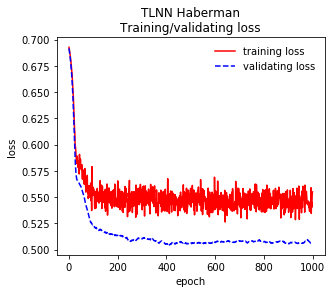

In [14]:
#----------------------------------------
# Summarize history for loss.

plt.figure('TLNN Haberman loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('TLNN Haberman' + '\n' + 'Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)
plt.show()


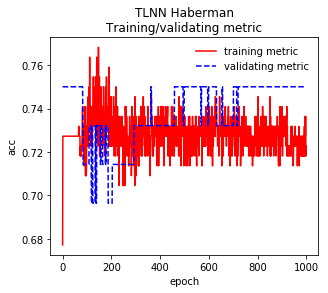

In [15]:
#----------------------------------------
# Summarize history for metric.

plt.figure('TLNN Haberman metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('TLNN Haberman' + '\n' + 'Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
plt.show()

